In [192]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import os

from importlib import reload

import small_utilities
reload(small_utilities)
import Block_analysis
reload(Block_analysis)

from Block_analysis import *
from small_utilities import *

import seaborn as sns

In [193]:
def reposition_first(array):
    if len(array.shape) == 2:  # Check if it's 2D
        # Reposition first row to the last
        return np.vstack((array[1:], array[0]))
    elif len(array.shape) == 3:  # Check if it's 3D
        # Reposition first slice to the last
        return np.concatenate((array[1:], array[:1]), axis=0)

import matplotlib.pyplot as plt
import numpy as np

def plot_colvar(colvar, trj_frames, num_cvs, labels, weights=None, out_dir=None):
    """
    Plot collective variables over time with corresponding histograms and reweighted histograms.

    Parameters:
        colvar (np.ndarray): Array of collective variables with time as the first column.
        trj_frames (dict): Dictionary mapping frame indices to frame times.
        num_cvs (int): Number of collective variables.
        labels (dict): Dictionary of labels for the collective variables.
        weights (np.ndarray, optional): Normalized weights for reweighting histograms. Must match the number of frames.
        out_dir (str, optional): Directory to save the plot. If None, the plot is shown but not saved.
    """
    # Configure subplots
    height_ratios = [1] * (num_cvs - 1)
    fig, axes = plt.subplots(
        num_cvs - 1, 2, figsize=(32, 40),
        gridspec_kw={
            'width_ratios': [4, 1],
            'height_ratios': height_ratios,
            'left': 0.1, 'right': 0.9,
            'bottom': 0.1, 'top': 0.9,
            'wspace': 0.02, 'hspace': 0.2
        },
        sharey=False,
        # sharex=True
    )

    # Check if weights are provided
    if weights is not None:
        if len(weights) != colvar.shape[0]:
            raise ValueError("Weights must match the number of frames in colvar.")
        weights = weights / np.sum(weights)  # Normalize weights

    # Loop over collective variables
    for i in range(num_cvs - 1):
        time = colvar.T[0] / 10**5  # Time in appropriate units
        data = colvar.T[i + 1]  # Data for the i-th collective variable

        # Line plot of collective variable over time
        axes[i, 0].plot(time, data, color='r', label=labels.get(str(i + 1), f'CV {i + 1}'))
        axes[i, 0].set_ylabel(labels.get(str(i + 1), f'CV {i + 1}'), size=35)
        axes[i, 0].set_xlabel(r"Time ($\mu$s)", size=35)
        axes[i, 0].tick_params(labelsize=25)
        xticks=[frame_time[1] / 10**5 for frame_idx, frame_time in trj_frames.items()]

        axes[i, 0].set_xticks(xticks)

        # Add vertical lines for trajectory frames
        for frame_idx, frame_time in trj_frames.items():
            axes[i, 0].axvline(x=frame_time[1] / 10**5, color='black', linewidth=3, linestyle='--')

        # Plot histogram
        axes[i, 1].hist(data, bins=50, orientation='horizontal', density=True, color='black', histtype='step', linewidth=2)

        # Plot reweighted histogram (if weights are provided)
        if weights is not None:
            # # Compute weighted histogram
            # hist, bin_edges = np.histogram(data, bins=50, density=True, weights=weights)
            # bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            # axes[i, 1].plot(hist, bin_centers, color='green', linewidth=2, label='Reweighted')
            axes[i, 1].hist(data, bins=50, orientation='horizontal', density=True, color='green', histtype='step', linewidth=2, weights=weights)


        axes[i, 1].tick_params(labelsize=25)
        axes[i, 1].set_yticks([])

    # Save or display the plot
    if out_dir:
        plt.savefig(f"{out_dir}/cv_plot.png", dpi=310, bbox_inches='tight')
    else:
        plt.show()

def create_trj_frames(colvar_data, nreps=16):
    """
    Create trajectory frame intervals based on the given data.

    Parameters:
        colvar_data (list): A list or array-like structure containing the data.
        nreps (int): Number of intervals (default is 16).
        index (int): Index of the dataset to process (default is 100).

    Returns:
        dict: A dictionary where keys are strings of interval indices and values are lists of start and end points.
    """
    # Determine the total length and calculate interval size
    total_frames = colvar_data.shape[0] - 1
    interval_size = total_frames / nreps

    # Initialize variables
    a, b = 0, interval_size
    trj_frames = {}

    # Create intervals
    for i in range(nreps):
        trj_frames[str(i)] = [a, b]
        a = b
        b += interval_size

    return trj_frames

## REST2 protein+Fasudil (10 replicas)

In [210]:
data_dir='/Volumes/128JK/work/REST_DATA/REST2/'
req_dir='data_fas_10'

rg=load_json(f'{data_dir}/{req_dir}/rg.json')
# sa=load_json(f'{data_dir}/{req_dir}/sa.json')
cm=load_json(f'{data_dir}/{req_dir}/contact_matrix.json')

# xvg_temp=np.loadtxt(f'{data_dir}/{req_dir}/replica_temp.xvg',comments=['#','@'])
# xvg_index=np.loadtxt(f'{data_dir}/{req_dir}/replica_index.xvg',comments=['#','@'])


In [211]:
X=np.array(rg['rep:0']) # appears on Y axis
Y=np.sum(cm['rep:0'], 1) # appears on X axis

assert X.shape[0]==Y.shape[0], "Shapes are not matching"

data=np.stack([X,Y])

Text(0.5, 1.0, '$\\alpha$-synuclein C-term :Fasudil')

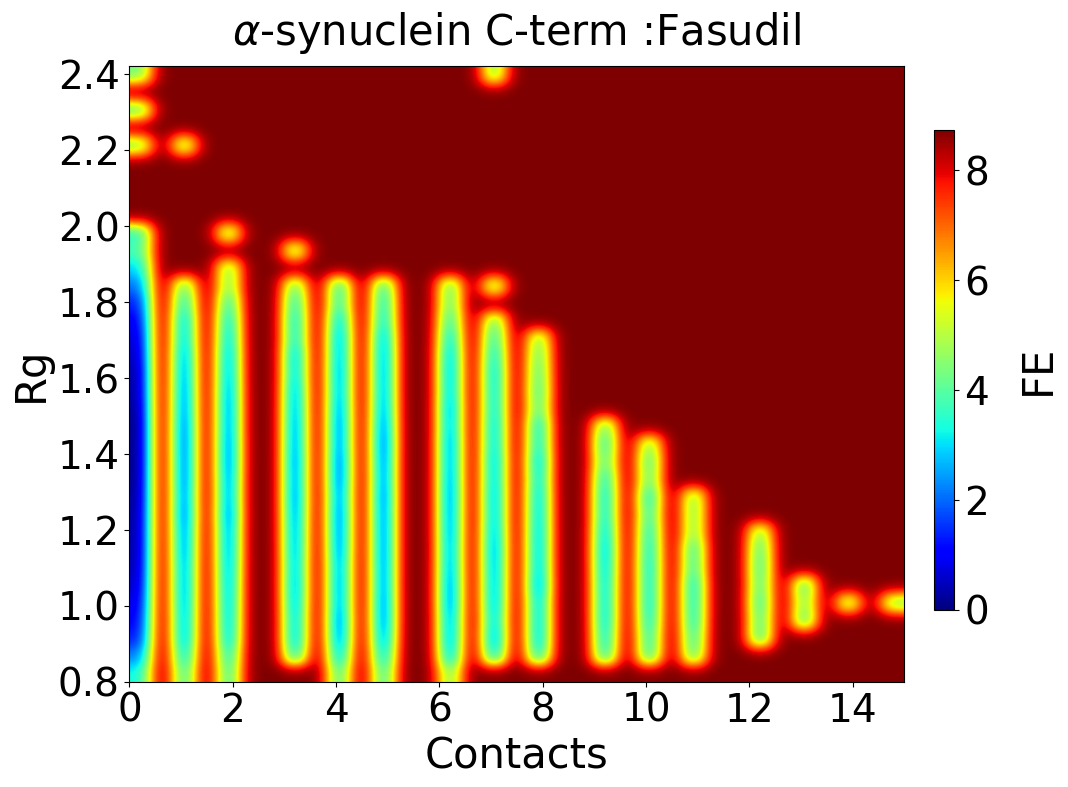

In [69]:
T=300
bins=35

# range=[[X.min()-0.2, X.max()+0.2], [Y.min()-2, Y.max()+2]]
# range=[[0.5, 2.25], [0, 17]]
range=[[X.min(), X.max()], [Y.min(), Y.max()]]

histo, xedges, yedges = np.histogram2d(x=X, y=Y, bins=bins, 
                                       range=range, 
                                       density=True)

xcenters = xedges[:-1] + np.diff(xedges)/2
ycenters = yedges[:-1] + np.diff(yedges)/2

free_energy = np.log(np.flipud(histo) + 0.000001)
free_energy = -(0.001987 * T) * free_energy
free_energy = free_energy-np.min(free_energy)

images=[]

fig, axes = plt.subplots(1, 1, figsize=(10,8))
cax= fig.add_axes([0.93, 0.2, 0.02, 0.6])

im = axes.imshow(free_energy, cmap='jet', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
            interpolation='gaussian')

images.append(im)
cbar = fig.colorbar(images[-1],cax=cax)
cbar.set_label("FE", size=30, labelpad=20)
cbar.ax.tick_params(labelsize=28)

axes.tick_params(labelsize=28)
axes.set_ylabel('Rg', size=30)
axes.set_xlabel('Contacts', size=30)

axes.set_xticks(np.arange(Y.min(), Y.max(), 2), np.arange(Y.min(), Y.max(), 2), rotation=0)
axes.set_yticks(np.arange(X.min(), X.max(), 0.2), [round(i, 1) for i in np.arange(X.min(), X.max(), 0.2)], rotation=0)
axes.grid(False)
axes.set_title(r'$\alpha$-synuclein C-term :Fasudil',size=30, pad=15)

In [70]:
def adjust_min(x):
    idx = (x == 0)
    x[idx] = x[~idx].min()
    return x

In [71]:
def free_energy_2D_blockerror(Y, X, bins=None, T:int=None, y0:float=None, ymax:float=None, x0:float=None,
                   xmax:float=None, weights=None, blocks=10):
    
    histo, xedges, yedges = np.histogram2d(
        Y, X, bins, [[y0, ymax], [x0, xmax]], density=True, weights=weights
    )
    # max = np.max(histo)
    # free_energy=-(0.001987*T)*np.log(histo)
    free_energy = -(0.001987*T)*np.log(np.flipud(histo)+.000001)
    free_energy = free_energy-np.min(free_energy)

    xcenters = xedges[:-1] + np.diff(xedges)/2
    ycenters = yedges[:-1] + np.diff(yedges)/2

    Ind = chunkIt(len(Y), blocks)
    block_size = (Ind[0][1]-Ind[0][0])
    hist_blocks = []
    # for i in range(0, len(Ind)):
    for i in np.arange(0, blocks):

        block_data_Y = Y[Ind[i][0]:Ind[i][1]]
        block_data_X = X[Ind[i][0]:Ind[i][1]]

        if weights is not None: block_weights = weights[Ind[i][0]:Ind[i][1]]
        else: block_weights = None

        hist, xedges, yedges = np.histogram2d(
            block_data_Y, block_data_X, bins, [[y0, ymax], [x0, xmax]], density=True, weights=block_weights
        )
        # hist, binedges = np.histogram(block_data, bins=bins, range=[
        #                             x0, xmax], density=True, weights=weights[Ind[i][0]:Ind[i][1]])
        hist_blocks.append(hist)
        
    hist_blocks = np.array(hist_blocks)
    average = np.average(hist_blocks, axis=0)
    variance = np.var(hist_blocks, axis=0)
    N = len(hist_blocks)
    error = np.sqrt(variance / N)
    ferr = -(0.001987*T)*(error / average)

    return free_energy, xcenters, ycenters, ferr, error

In [72]:
fe, xedges,yedges, ferr, err = free_energy_2D_blockerror(Y=X, X=Y, bins=35, T=300, y0=X.min(), ymax=X.max(),
                                                        x0=Y.min(), xmax=Y.max(), weights=None, blocks=500)


/var/folders/s4/rkgttpts2xl9drlltn1361m00000gn/T/ipykernel_15336/4038208200.py:39: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)


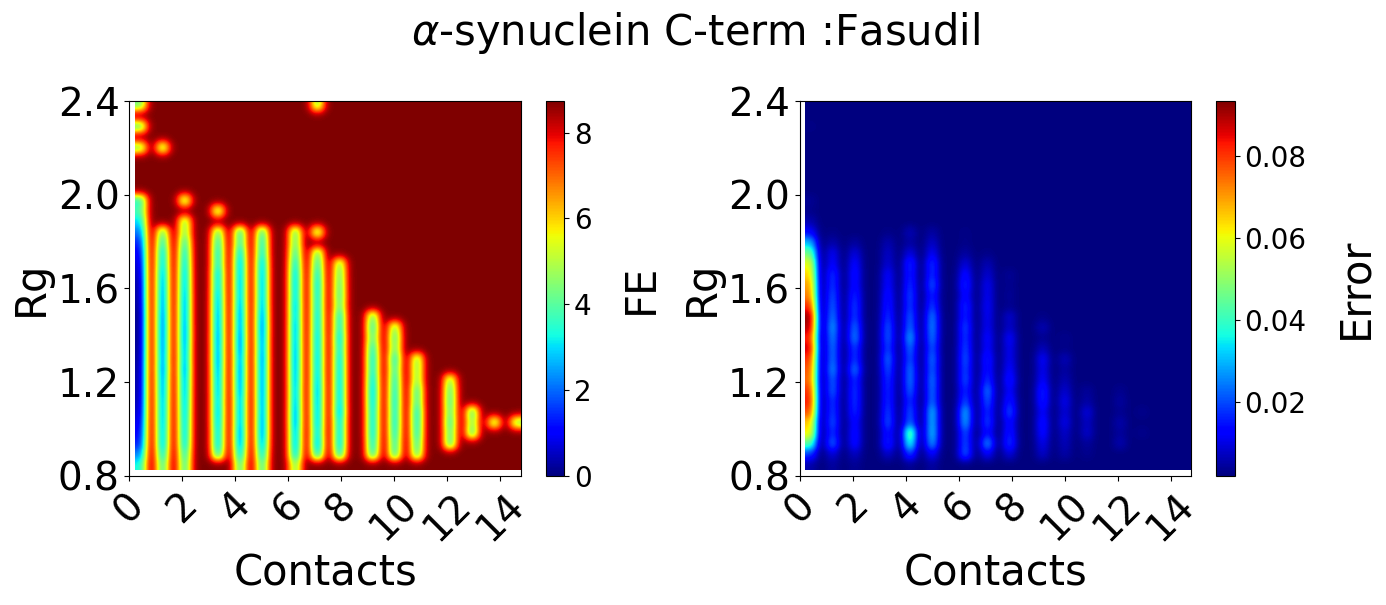

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
ax=axes.flat

s1 = ax[0].imshow(fe, cmap='jet', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
            interpolation='gaussian')
cbar = fig.colorbar(s1, ax=ax[0])
cbar.set_label("FE", size=30, labelpad=20)
cbar.ax.tick_params(labelsize=20)

ax[0].tick_params(labelsize=28)
ax[0].set_ylabel('Rg', size=30)
ax[0].set_xlabel('Contacts', size=30)

ax[0].set_xticks(np.arange(Y.min(), Y.max(), 2), np.arange(Y.min(), Y.max(), 2), rotation=45)
ax[0].set_yticks(np.arange(X.min(), X.max(), 0.4), [round(i, 1) for i in np.arange(X.min(), X.max(), 0.4)], rotation=0)
ax[0].grid(False)
# ax[0].set_title(r'$\alpha$-synuclein C-term :Fasudil',size=30, pad=15)

s2 = ax[1].imshow(np.flip(adjust_min(err), 0), cmap='jet', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
            interpolation='gaussian')
# plt.colorbar(s2, ax=ax[1], label="Error")
cbar = fig.colorbar(s2, ax=ax[1])
cbar.set_label("Error", size=30, labelpad=20)
cbar.ax.tick_params(labelsize=20)

ax[1].tick_params(labelsize=28)
ax[1].set_ylabel('Rg', size=30)
ax[1].set_xlabel('Contacts', size=30)

ax[1].set_xticks(np.arange(Y.min(), Y.max(), 2), np.arange(Y.min(), Y.max(), 2), rotation=45)
ax[1].set_yticks(np.arange(X.min(), X.max(), 0.4), [round(i, 1) for i in np.arange(X.min(), X.max(), 0.4)], rotation=0)
ax[1].grid(False)

plt.suptitle(r'$\alpha$-synuclein C-term :Fasudil',size=30, y=1.0)

plt.tight_layout()

In [212]:
bins=2

_, xedges, yedges = np.histogram2d(x=X, y=Y, bins=bins, range=[[X.min(), X.max()], [Y.min(), Y.max()]], density=True)

rg_bor, lc_bor = xedges , yedges
print(rg_bor, lc_bor)

[0.76938856 1.58043417 2.39147978] [ 0.   7.5 15. ]


In [213]:
q1_1d=np.zeros(len(X))
q2_1d=np.zeros(len(X))
q3_1d=np.zeros(len(X))
q4_1d=np.zeros(len(X))
index=0

for rg,lc in zip(X,Y):

    if rg_bor[0]<=rg<=rg_bor[1] and lc_bor[0]<=lc<=lc_bor[1]: q1_1d[index]=1
    else : q1_1d[index]=0

    if rg_bor[1]<rg<=rg_bor[2] and lc_bor[0]<=lc<=lc_bor[1]: q2_1d[index]=1
    else : q2_1d[index]=0

    if rg_bor[1]<rg<=rg_bor[2] and lc_bor[1]<lc<=lc_bor[2]: q3_1d[index]=1
    else : q3_1d[index]=0

    if rg_bor[0]<=rg<=rg_bor[1] and lc_bor[1]<lc<=lc_bor[2]: q4_1d[index]=1
    else : q4_1d[index]=0

    index+=1
    

In [214]:
print(f'Q1 : {round(rg_bor[0],4)} <= rg <= {round(rg_bor[1], 4)} and {round(lc_bor[0], 4)} <= lc <= {round(lc_bor[1], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip(q1_1d)}\n')
print(f'Q2 : {round(rg_bor[1],4)} < rg <= {round(rg_bor[2], 4)} and {round(lc_bor[0], 4)} <= lc <= {round(lc_bor[1], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip(q2_1d)}\n')
print(f'Q3 : {round(rg_bor[1],4)} < rg <= {round(rg_bor[2], 4)} and {round(lc_bor[1], 4)} < lc <= {round(lc_bor[2], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip(q3_1d)}\n')
print(f'Q4 : {round(rg_bor[0],4)} <= rg <= {round(rg_bor[1], 4)} and {round(lc_bor[1], 4)} < lc <= {round(lc_bor[2], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip(q4_1d)}\n')


Q1 : 0.7694 <= rg <= 1.5804 and 0.0 <= lc <= 7.5 : 
Prob, B_err : (0.8485921223958334, 0.005672801272247753)

Q2 : 1.5804 < rg <= 2.3915 and 0.0 <= lc <= 7.5 : 
Prob, B_err : (0.11275227864583333, 0.006048389290110785)

Q3 : 1.5804 < rg <= 2.3915 and 7.5 < lc <= 15.0 : 
Prob, B_err : (0.000244140625, 0.0001405861460299246)

Q4 : 0.7694 <= rg <= 1.5804 and 7.5 < lc <= 15.0 : 
Prob, B_err : (0.038411458333333336, 0.004238881509070465)



## REST2 protein+Fasudil (20 replicas)


In [215]:
data_dir='/Volumes/128JK/work/REST_DATA/REST2/'
req_dir='data_fas_20'

rg=load_json(f'{data_dir}/{req_dir}/rg.json')
# sa=load_json(f'{data_dir}/{req_dir}/sa.json')
cm=load_json(f'{data_dir}/{req_dir}/contact_matrix.json')

# xvg_temp=np.loadtxt(f'{data_dir}/{req_dir}/replica_temp.xvg',comments=['#','@'])
# xvg_index=np.loadtxt(f'{data_dir}/{req_dir}/replica_index.xvg',comments=['#','@'])


In [216]:
X=np.array(rg['rep:0']) # appears on Y axis
Y=np.sum(cm['rep:0'], 1) # appears on X axis

assert X.shape[0]==Y.shape[0], "Shapes are not matching"

data=np.stack([X,Y])

Text(0.5, 1.0, '$\\alpha$-synuclein C-term :Fasudil')

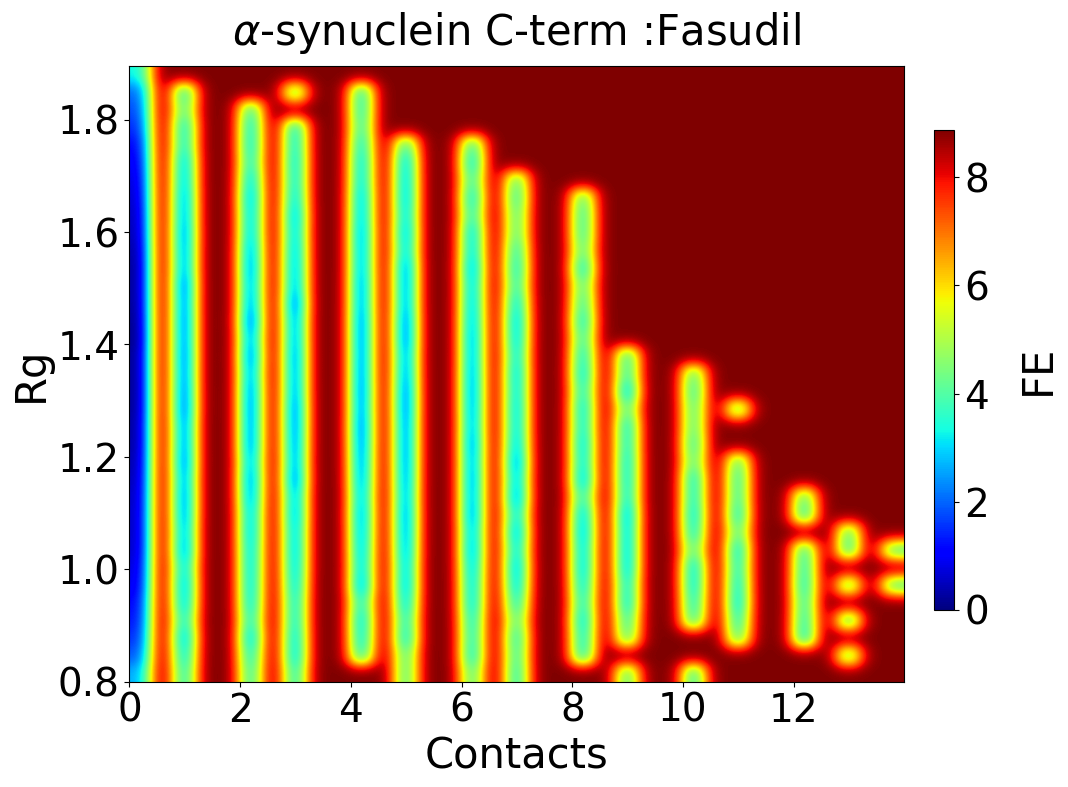

In [217]:
T=300
bins=35

# range=[[X.min()-0.2, X.max()+0.2], [Y.min()-2, Y.max()+2]]
# range=[[0.5, 2.25], [0, 17]]
range=[[X.min(), X.max()], [Y.min(), Y.max()]]

histo, xedges, yedges = np.histogram2d(x=X, y=Y, bins=bins, 
                                       range=range, 
                                       density=True)

xcenters = xedges[:-1] + np.diff(xedges)/2
ycenters = yedges[:-1] + np.diff(yedges)/2

free_energy = np.log(np.flipud(histo) + 0.000001)
free_energy = -(0.001987 * T) * free_energy
free_energy = free_energy-np.min(free_energy)

images=[]

fig, axes = plt.subplots(1, 1, figsize=(10,8))
cax= fig.add_axes([0.93, 0.2, 0.02, 0.6])

im = axes.imshow(free_energy, cmap='jet', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
            interpolation='gaussian')

images.append(im)
cbar = fig.colorbar(images[-1],cax=cax)
cbar.set_label("FE", size=30, labelpad=20)
cbar.ax.tick_params(labelsize=28)

axes.tick_params(labelsize=28)
axes.set_ylabel('Rg', size=30)
axes.set_xlabel('Contacts', size=30)

axes.set_xticks(np.arange(Y.min(), Y.max(), 2), np.arange(Y.min(), Y.max(), 2), rotation=0)
axes.set_yticks(np.arange(X.min(), X.max(), 0.2), [round(i, 1) for i in np.arange(X.min(), X.max(), 0.2)], rotation=0)
axes.grid(False)
axes.set_title(r'$\alpha$-synuclein C-term :Fasudil',size=30, pad=15)

In [202]:
fe, xedges,yedges, ferr, err = free_energy_2D_blockerror(Y=X, X=Y, bins=35, T=300, y0=X.min(), ymax=X.max(),
                                                        x0=Y.min(), xmax=Y.max(), weights=None, blocks=500)


/var/folders/s4/rkgttpts2xl9drlltn1361m00000gn/T/ipykernel_15336/4038208200.py:39: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)


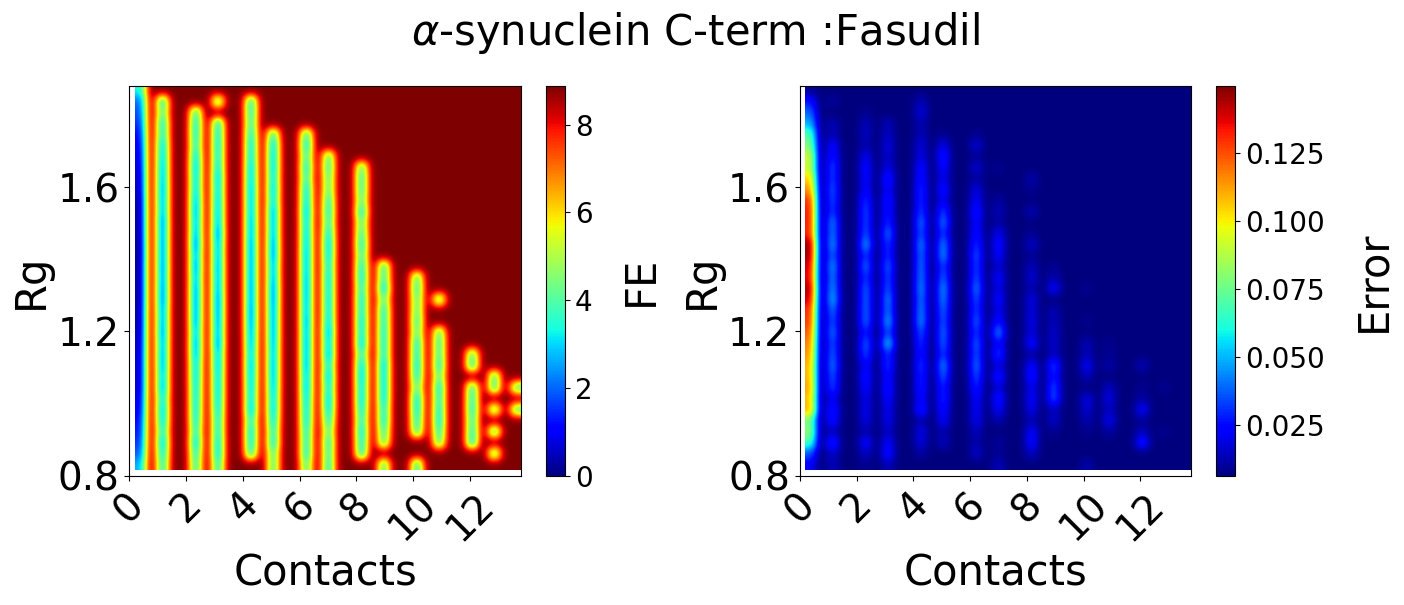

In [203]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
ax=axes.flat

s1 = ax[0].imshow(fe, cmap='jet', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
            interpolation='gaussian')
cbar = fig.colorbar(s1, ax=ax[0])
cbar.set_label("FE", size=30, labelpad=20)
cbar.ax.tick_params(labelsize=20)

ax[0].tick_params(labelsize=28)
ax[0].set_ylabel('Rg', size=30)
ax[0].set_xlabel('Contacts', size=30)

ax[0].set_xticks(np.arange(Y.min(), Y.max(), 2), np.arange(Y.min(), Y.max(), 2), rotation=45)
ax[0].set_yticks(np.arange(X.min(), X.max(), 0.4), [round(i, 1) for i in np.arange(X.min(), X.max(), 0.4)], rotation=0)
ax[0].grid(False)
# ax[0].set_title(r'$\alpha$-synuclein C-term :Fasudil',size=30, pad=15)

s2 = ax[1].imshow(np.flip(adjust_min(err), 0), cmap='jet', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
            interpolation='gaussian')
# plt.colorbar(s2, ax=ax[1], label="Error")
cbar = fig.colorbar(s2, ax=ax[1])
cbar.set_label("Error", size=30, labelpad=20)
cbar.ax.tick_params(labelsize=20)

ax[1].tick_params(labelsize=28)
ax[1].set_ylabel('Rg', size=30)
ax[1].set_xlabel('Contacts', size=30)

ax[1].set_xticks(np.arange(Y.min(), Y.max(), 2), np.arange(Y.min(), Y.max(), 2), rotation=45)
ax[1].set_yticks(np.arange(X.min(), X.max(), 0.4), [round(i, 1) for i in np.arange(X.min(), X.max(), 0.4)], rotation=0)
ax[1].grid(False)

plt.suptitle(r'$\alpha$-synuclein C-term :Fasudil',size=30, y=1.0)

plt.tight_layout()

In [218]:
bins=2

_, xedges, yedges = np.histogram2d(x=X, y=Y, bins=bins, range=[[X.min(), X.max()], [Y.min(), Y.max()]], density=True)

rg_bor, lc_bor = xedges , yedges
print(rg_bor, lc_bor)

[0.78010505 1.32804272 1.87598039] [ 0.  7. 14.]


In [219]:
q1_1d=np.zeros(len(X))
q2_1d=np.zeros(len(X))
q3_1d=np.zeros(len(X))
q4_1d=np.zeros(len(X))
index=0

for rg,lc in zip(X,Y):

    if rg_bor[0]<=rg<=rg_bor[1] and lc_bor[0]<=lc<=lc_bor[1]: q1_1d[index]=1
    else : q1_1d[index]=0

    if rg_bor[1]<rg<=rg_bor[2] and lc_bor[0]<=lc<=lc_bor[1]: q2_1d[index]=1
    else : q2_1d[index]=0

    if rg_bor[1]<rg<=rg_bor[2] and lc_bor[1]<lc<=lc_bor[2]: q3_1d[index]=1
    else : q3_1d[index]=0

    if rg_bor[0]<=rg<=rg_bor[1] and lc_bor[1]<lc<=lc_bor[2]: q4_1d[index]=1
    else : q4_1d[index]=0

    index+=1
    

In [220]:
print(f'Q1 : {round(rg_bor[0],4)} <= rg <= {round(rg_bor[1], 4)} and {round(lc_bor[0], 4)} <= lc <= {round(lc_bor[1], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip(q1_1d)}\n')
print(f'Q2 : {round(rg_bor[1],4)} < rg <= {round(rg_bor[2], 4)} and {round(lc_bor[0], 4)} <= lc <= {round(lc_bor[1], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip(q2_1d)}\n')
print(f'Q3 : {round(rg_bor[1],4)} < rg <= {round(rg_bor[2], 4)} and {round(lc_bor[1], 4)} < lc <= {round(lc_bor[2], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip(q3_1d)}\n')
print(f'Q4 : {round(rg_bor[0],4)} <= rg <= {round(rg_bor[1], 4)} and {round(lc_bor[1], 4)} < lc <= {round(lc_bor[2], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip(q4_1d)}\n')


Q1 : 0.7801 <= rg <= 1.328 and 0.0 <= lc <= 7.0 : 
Prob, B_err : (0.48980081593472524, 0.011762829850332062)

Q2 : 1.328 < rg <= 1.876 and 0.0 <= lc <= 7.0 : 
Prob, B_err : (0.47644188464922804, 0.012051499852443543)

Q3 : 1.328 < rg <= 1.876 and 7.0 < lc <= 14.0 : 
Prob, B_err : (0.0027197824174066076, 0.0006329202736699233)

Q4 : 0.7801 <= rg <= 1.328 and 7.0 < lc <= 14.0 : 
Prob, B_err : (0.03103751699864011, 0.004342478726338969)



## REST2 protein+Ligand 47 (10 replicas)

In [221]:
data_dir='/Volumes/128JK/work/REST_DATA/REST2/'
req_dir='data_lig47_10'

rg=load_json(f'{data_dir}/{req_dir}/rg.json')
# sa=load_json(f'{data_dir}/{req_dir}/sa.json')
cm=load_json(f'{data_dir}/{req_dir}/contact_matrix.json')

# xvg_temp=np.loadtxt(f'{data_dir}/{req_dir}/replica_temp.xvg',comments=['#','@'])
# xvg_index=np.loadtxt(f'{data_dir}/{req_dir}/replica_index.xvg',comments=['#','@'])


In [222]:
X=np.array(rg['rep:0']) # appears on Y axis
Y=np.sum(cm['rep:0'], 1) # appears on X axis

assert X.shape[0]==Y.shape[0], "Shapes are not matching"

data=np.stack([X,Y])

Text(0.5, 1.0, '$\\alpha$-synuclein C-term :Ligand 47')

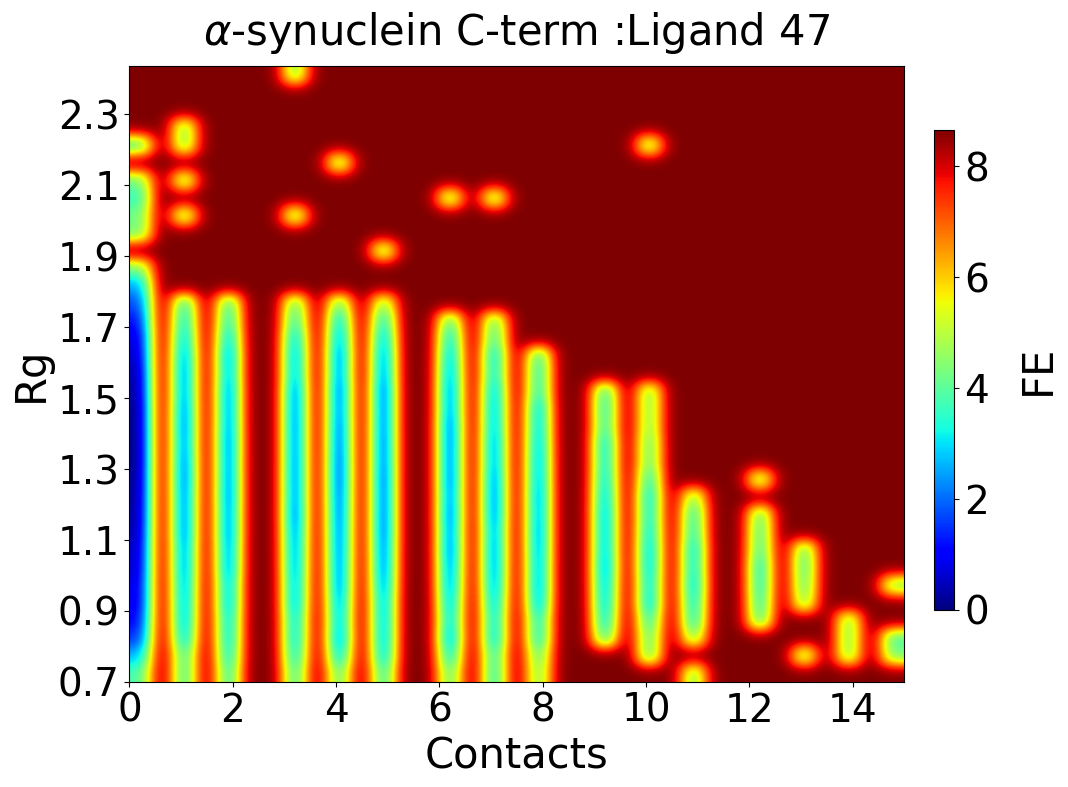

In [223]:
T=300
bins=35

# range=[[X.min()-0.2, X.max()+0.2], [Y.min()-2, Y.max()+2]]
# range=[[0.5, 2.25], [0, 17]]
range=[[X.min(), X.max()], [Y.min(), Y.max()]]

histo, xedges, yedges = np.histogram2d(x=X, y=Y, bins=bins, 
                                       range=range, 
                                       density=True)

xcenters = xedges[:-1] + np.diff(xedges)/2
ycenters = yedges[:-1] + np.diff(yedges)/2

free_energy = np.log(np.flipud(histo) + 0.000001)
free_energy = -(0.001987 * T) * free_energy
free_energy = free_energy-np.min(free_energy)

images=[]

fig, axes = plt.subplots(1, 1, figsize=(10,8))
cax= fig.add_axes([0.93, 0.2, 0.02, 0.6])

im = axes.imshow(free_energy, cmap='jet', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
            interpolation='gaussian')

images.append(im)
cbar = fig.colorbar(images[-1],cax=cax)
cbar.set_label("FE", size=30, labelpad=20)
cbar.ax.tick_params(labelsize=28)

axes.tick_params(labelsize=28)
axes.set_ylabel('Rg', size=30)
axes.set_xlabel('Contacts', size=30)

axes.set_xticks(np.arange(Y.min(), Y.max(), 2), np.arange(Y.min(), Y.max(), 2), rotation=0)
axes.set_yticks(np.arange(X.min(), X.max(), 0.2), [round(i, 1) for i in np.arange(X.min(), X.max(), 0.2)], rotation=0)
axes.grid(False)
axes.set_title(r'$\alpha$-synuclein C-term :Ligand 47',size=30, pad=15)

In [224]:
fe, xedges,yedges, ferr, err = free_energy_2D_blockerror(Y=X, X=Y, bins=35, T=300, y0=X.min(), ymax=X.max(),
                                                        x0=Y.min(), xmax=Y.max(), weights=None, blocks=500)


/var/folders/s4/rkgttpts2xl9drlltn1361m00000gn/T/ipykernel_15336/4038208200.py:39: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)


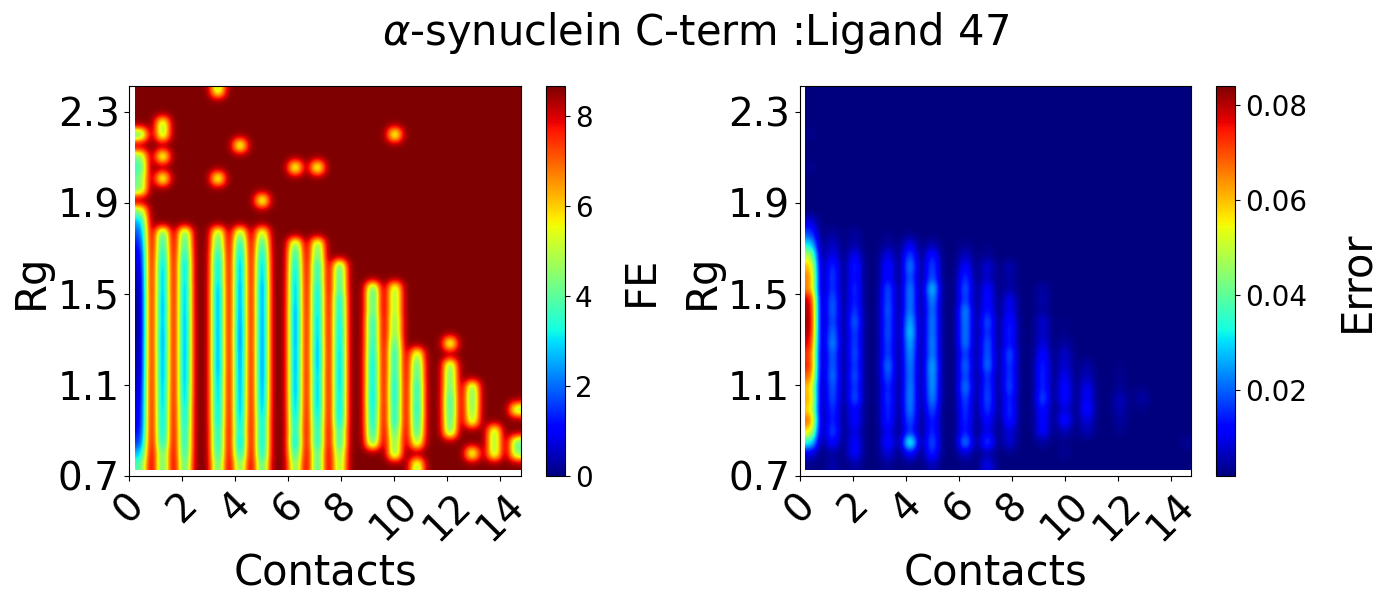

In [225]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
ax=axes.flat

s1 = ax[0].imshow(fe, cmap='jet', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
            interpolation='gaussian')
cbar = fig.colorbar(s1, ax=ax[0])
cbar.set_label("FE", size=30, labelpad=20)
cbar.ax.tick_params(labelsize=20)

ax[0].tick_params(labelsize=28)
ax[0].set_ylabel('Rg', size=30)
ax[0].set_xlabel('Contacts', size=30)

ax[0].set_xticks(np.arange(Y.min(), Y.max(), 2), np.arange(Y.min(), Y.max(), 2), rotation=45)
ax[0].set_yticks(np.arange(X.min(), X.max(), 0.4), [round(i, 1) for i in np.arange(X.min(), X.max(), 0.4)], rotation=0)
ax[0].grid(False)
# ax[0].set_title(r'$\alpha$-synuclein C-term :Fasudil',size=30, pad=15)

s2 = ax[1].imshow(np.flip(adjust_min(err), 0), cmap='jet', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
            interpolation='gaussian')
# plt.colorbar(s2, ax=ax[1], label="Error")
cbar = fig.colorbar(s2, ax=ax[1])
cbar.set_label("Error", size=30, labelpad=20)
cbar.ax.tick_params(labelsize=20)

ax[1].tick_params(labelsize=28)
ax[1].set_ylabel('Rg', size=30)
ax[1].set_xlabel('Contacts', size=30)

ax[1].set_xticks(np.arange(Y.min(), Y.max(), 2), np.arange(Y.min(), Y.max(), 2), rotation=45)
ax[1].set_yticks(np.arange(X.min(), X.max(), 0.4), [round(i, 1) for i in np.arange(X.min(), X.max(), 0.4)], rotation=0)
ax[1].grid(False)

plt.suptitle(r'$\alpha$-synuclein C-term :Ligand 47',size=30, y=1.0)

plt.tight_layout()

In [226]:
bins=2

_, xedges, yedges = np.histogram2d(x=X, y=Y, bins=bins, range=[[X.min(), X.max()], [Y.min(), Y.max()]], density=True)

rg_bor, lc_bor = xedges , yedges
print(rg_bor, lc_bor)

[0.74583496 1.61458452 2.48333408] [ 0.   7.5 15. ]


In [227]:
q1_1d=np.zeros(len(X))
q2_1d=np.zeros(len(X))
q3_1d=np.zeros(len(X))
q4_1d=np.zeros(len(X))
index=0

for rg,lc in zip(X,Y):

    if rg_bor[0]<=rg<=rg_bor[1] and lc_bor[0]<=lc<=lc_bor[1]: q1_1d[index]=1
    else : q1_1d[index]=0

    if rg_bor[1]<rg<=rg_bor[2] and lc_bor[0]<=lc<=lc_bor[1]: q2_1d[index]=1
    else : q2_1d[index]=0

    if rg_bor[1]<rg<=rg_bor[2] and lc_bor[1]<lc<=lc_bor[2]: q3_1d[index]=1
    else : q3_1d[index]=0

    if rg_bor[0]<=rg<=rg_bor[1] and lc_bor[1]<lc<=lc_bor[2]: q4_1d[index]=1
    else : q4_1d[index]=0

    index+=1
    

In [228]:
print(f'Q1 : {round(rg_bor[0],4)} <= rg <= {round(rg_bor[1], 4)} and {round(lc_bor[0], 4)} <= lc <= {round(lc_bor[1], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip(q1_1d)}\n')
print(f'Q2 : {round(rg_bor[1],4)} < rg <= {round(rg_bor[2], 4)} and {round(lc_bor[0], 4)} <= lc <= {round(lc_bor[1], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip(q2_1d)}\n')
print(f'Q3 : {round(rg_bor[1],4)} < rg <= {round(rg_bor[2], 4)} and {round(lc_bor[1], 4)} < lc <= {round(lc_bor[2], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip(q3_1d)}\n')
print(f'Q4 : {round(rg_bor[0],4)} <= rg <= {round(rg_bor[1], 4)} and {round(lc_bor[1], 4)} < lc <= {round(lc_bor[2], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip(q4_1d)}\n')


Q1 : 0.7458 <= rg <= 1.6146 and 0.0 <= lc <= 7.5 : 
Prob, B_err : (0.8452861885524579, 0.007595645666357494)

Q2 : 1.6146 < rg <= 2.4833 and 0.0 <= lc <= 7.5 : 
Prob, B_err : (0.09603615855365785, 0.004717809283922215)

Q3 : 1.6146 < rg <= 2.4833 and 7.5 < lc <= 15.0 : 
Prob, B_err : (0.0003999840006399744, 0.0001870589724931395)

Q4 : 0.7458 <= rg <= 1.6146 and 7.5 < lc <= 15.0 : 
Prob, B_err : (0.05827766889324427, 0.005946538995716075)



## REST2 protein+Ligand 47 (20 replicas)

In [229]:
data_dir='/Volumes/128JK/work/REST_DATA/REST2/'
req_dir='data_lig47_20'

rg=load_json(f'{data_dir}/{req_dir}/rg.json')
# sa=load_json(f'{data_dir}/{req_dir}/sa.json')
cm=load_json(f'{data_dir}/{req_dir}/contact_matrix.json')

# xvg_temp=np.loadtxt(f'{data_dir}/{req_dir}/replica_temp.xvg',comments=['#','@'])
# xvg_index=np.loadtxt(f'{data_dir}/{req_dir}/replica_index.xvg',comments=['#','@'])


In [230]:
X=np.array(rg['rep:0']) # appears on Y axis
Y=np.sum(cm['rep:0'], 1) # appears on X axis

assert X.shape[0]==Y.shape[0], "Shapes are not matching"

data=np.stack([X,Y])

Text(0.5, 1.0, '$\\alpha$-synuclein C-term :Ligand 47')

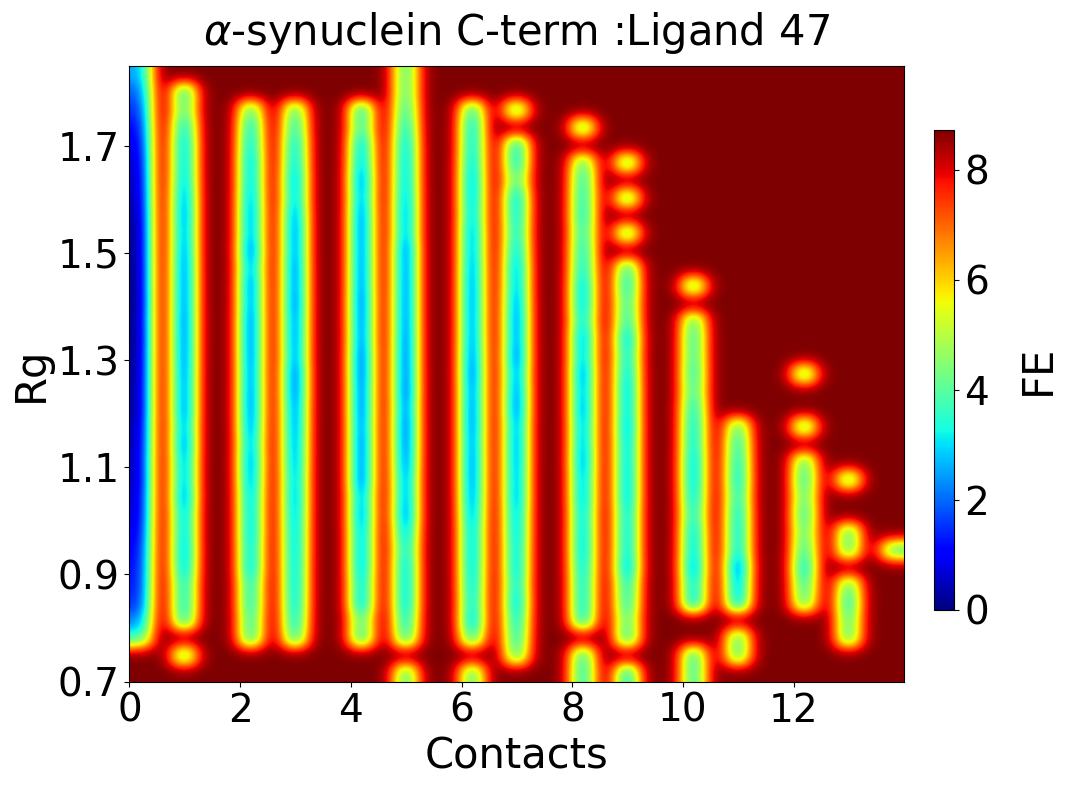

In [231]:
T=300
bins=35

# range=[[X.min()-0.2, X.max()+0.2], [Y.min()-2, Y.max()+2]]
# range=[[0.5, 2.25], [0, 17]]
range=[[X.min(), X.max()], [Y.min(), Y.max()]]

histo, xedges, yedges = np.histogram2d(x=X, y=Y, bins=bins, 
                                       range=range, 
                                       density=True)

xcenters = xedges[:-1] + np.diff(xedges)/2
ycenters = yedges[:-1] + np.diff(yedges)/2

free_energy = np.log(np.flipud(histo) + 0.000001)
free_energy = -(0.001987 * T) * free_energy
free_energy = free_energy-np.min(free_energy)

images=[]

fig, axes = plt.subplots(1, 1, figsize=(10,8))
cax= fig.add_axes([0.93, 0.2, 0.02, 0.6])

im = axes.imshow(free_energy, cmap='jet', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
            interpolation='gaussian')

images.append(im)
cbar = fig.colorbar(images[-1],cax=cax)
cbar.set_label("FE", size=30, labelpad=20)
cbar.ax.tick_params(labelsize=28)

axes.tick_params(labelsize=28)
axes.set_ylabel('Rg', size=30)
axes.set_xlabel('Contacts', size=30)

axes.set_xticks(np.arange(Y.min(), Y.max(), 2), np.arange(Y.min(), Y.max(), 2), rotation=0)
axes.set_yticks(np.arange(X.min(), X.max(), 0.2), [round(i, 1) for i in np.arange(X.min(), X.max(), 0.2)], rotation=0)
axes.grid(False)
axes.set_title(r'$\alpha$-synuclein C-term :Ligand 47',size=30, pad=15)

In [232]:
fe, xedges,yedges, ferr, err = free_energy_2D_blockerror(Y=X, X=Y, bins=35, T=300, y0=X.min(), ymax=X.max(),
                                                        x0=Y.min(), xmax=Y.max(), weights=None, blocks=500)


/var/folders/s4/rkgttpts2xl9drlltn1361m00000gn/T/ipykernel_15336/4038208200.py:39: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)


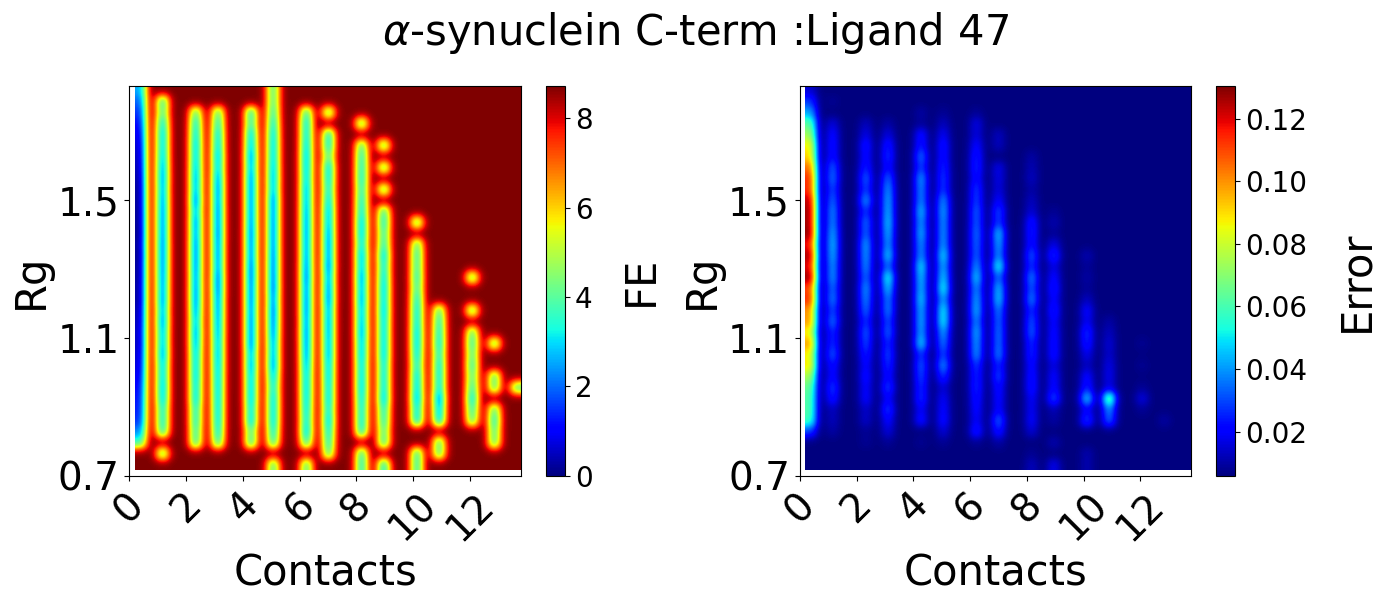

In [233]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
ax=axes.flat

s1 = ax[0].imshow(fe, cmap='jet', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
            interpolation='gaussian')
cbar = fig.colorbar(s1, ax=ax[0])
cbar.set_label("FE", size=30, labelpad=20)
cbar.ax.tick_params(labelsize=20)

ax[0].tick_params(labelsize=28)
ax[0].set_ylabel('Rg', size=30)
ax[0].set_xlabel('Contacts', size=30)

ax[0].set_xticks(np.arange(Y.min(), Y.max(), 2), np.arange(Y.min(), Y.max(), 2), rotation=45)
ax[0].set_yticks(np.arange(X.min(), X.max(), 0.4), [round(i, 1) for i in np.arange(X.min(), X.max(), 0.4)], rotation=0)
ax[0].grid(False)
# ax[0].set_title(r'$\alpha$-synuclein C-term :Fasudil',size=30, pad=15)

s2 = ax[1].imshow(np.flip(adjust_min(err), 0), cmap='jet', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
            interpolation='gaussian')
# plt.colorbar(s2, ax=ax[1], label="Error")
cbar = fig.colorbar(s2, ax=ax[1])
cbar.set_label("Error", size=30, labelpad=20)
cbar.ax.tick_params(labelsize=20)

ax[1].tick_params(labelsize=28)
ax[1].set_ylabel('Rg', size=30)
ax[1].set_xlabel('Contacts', size=30)

ax[1].set_xticks(np.arange(Y.min(), Y.max(), 2), np.arange(Y.min(), Y.max(), 2), rotation=45)
ax[1].set_yticks(np.arange(X.min(), X.max(), 0.4), [round(i, 1) for i in np.arange(X.min(), X.max(), 0.4)], rotation=0)
ax[1].grid(False)

plt.suptitle(r'$\alpha$-synuclein C-term :Ligand 47',size=30, y=1.0)

plt.tight_layout()

In [234]:
bins=2

_, xedges, yedges = np.histogram2d(x=X, y=Y, bins=bins, range=[[X.min(), X.max()], [Y.min(), Y.max()]], density=True)

rg_bor, lc_bor = xedges , yedges
print(rg_bor, lc_bor)

[0.72651557 1.30095163 1.87538768] [ 0.  7. 14.]


In [235]:
q1_1d=np.zeros(len(X))
q2_1d=np.zeros(len(X))
q3_1d=np.zeros(len(X))
q4_1d=np.zeros(len(X))
index=0

for rg,lc in zip(X,Y):

    if rg_bor[0]<=rg<=rg_bor[1] and lc_bor[0]<=lc<=lc_bor[1]: q1_1d[index]=1
    else : q1_1d[index]=0

    if rg_bor[1]<rg<=rg_bor[2] and lc_bor[0]<=lc<=lc_bor[1]: q2_1d[index]=1
    else : q2_1d[index]=0

    if rg_bor[1]<rg<=rg_bor[2] and lc_bor[1]<lc<=lc_bor[2]: q3_1d[index]=1
    else : q3_1d[index]=0

    if rg_bor[0]<=rg<=rg_bor[1] and lc_bor[1]<lc<=lc_bor[2]: q4_1d[index]=1
    else : q4_1d[index]=0

    index+=1
    

In [236]:
print(f'Q1 : {round(rg_bor[0],4)} <= rg <= {round(rg_bor[1], 4)} and {round(lc_bor[0], 4)} <= lc <= {round(lc_bor[1], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip(q1_1d)}\n')
print(f'Q2 : {round(rg_bor[1],4)} < rg <= {round(rg_bor[2], 4)} and {round(lc_bor[0], 4)} <= lc <= {round(lc_bor[1], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip(q2_1d)}\n')
print(f'Q3 : {round(rg_bor[1],4)} < rg <= {round(rg_bor[2], 4)} and {round(lc_bor[1], 4)} < lc <= {round(lc_bor[2], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip(q3_1d)}\n')
print(f'Q4 : {round(rg_bor[0],4)} <= rg <= {round(rg_bor[1], 4)} and {round(lc_bor[1], 4)} < lc <= {round(lc_bor[2], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip(q4_1d)}\n')


Q1 : 0.7265 <= rg <= 1.301 and 0.0 <= lc <= 7.0 : 
Prob, B_err : (0.3795771838851217, 0.010870655477450761)

Q2 : 1.301 < rg <= 1.8754 and 0.0 <= lc <= 7.0 : 
Prob, B_err : (0.5492620662145992, 0.011410438925834711)

Q3 : 1.301 < rg <= 1.8754 and 7.0 < lc <= 14.0 : 
Prob, B_err : (0.013721579577183885, 0.002279858867947841)

Q4 : 0.7265 <= rg <= 1.301 and 7.0 < lc <= 14.0 : 
Prob, B_err : (0.05743917032309533, 0.010513551757172224)



## ssREST3 protein+Fasudil (8 replicas)

In [237]:
data_dir='/Volumes/128JK/work/REST_DATA/ssREST3/'
req_dir='data_fas_8'

rg=load_json(f'{data_dir}/{req_dir}/rg.json')
# sa=load_json(f'{data_dir}/{req_dir}/sa.json')
cm=load_json(f'{data_dir}/{req_dir}/contact_matrix.json')

# xvg_temp=np.loadtxt(f'{data_dir}/{req_dir}/replica_temp.xvg',comments=['#','@'])
# xvg_index=np.loadtxt(f'{data_dir}/{req_dir}/replica_index.xvg',comments=['#','@'])


In [238]:
X=np.array(rg['rep:0']) # appears on Y axis
Y=np.sum(cm['rep:0'], 1) # appears on X axis

assert X.shape[0]==Y.shape[0], "Shapes are not matching"

data=np.stack([X,Y])

Text(0.5, 1.0, '$\\alpha$-synuclein C-term :Fasudil')

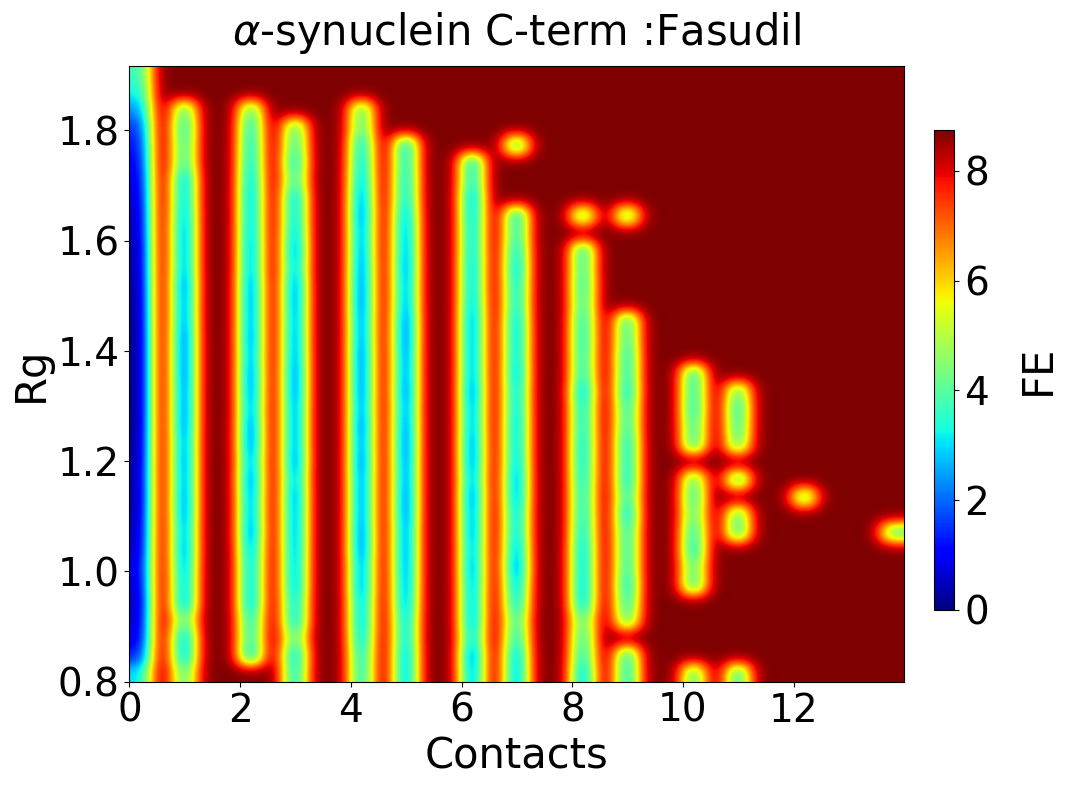

In [239]:
T=300
bins=35

# range=[[X.min()-0.2, X.max()+0.2], [Y.min()-2, Y.max()+2]]
# range=[[0.5, 2.25], [0, 17]]
range=[[X.min(), X.max()], [Y.min(), Y.max()]]

histo, xedges, yedges = np.histogram2d(x=X, y=Y, bins=bins, 
                                       range=range, 
                                       density=True)

xcenters = xedges[:-1] + np.diff(xedges)/2
ycenters = yedges[:-1] + np.diff(yedges)/2

free_energy = np.log(np.flipud(histo) + 0.000001)
free_energy = -(0.001987 * T) * free_energy
free_energy = free_energy-np.min(free_energy)

images=[]

fig, axes = plt.subplots(1, 1, figsize=(10,8))
cax= fig.add_axes([0.93, 0.2, 0.02, 0.6])

im = axes.imshow(free_energy, cmap='jet', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
            interpolation='gaussian')

images.append(im)
cbar = fig.colorbar(images[-1],cax=cax)
cbar.set_label("FE", size=30, labelpad=20)
cbar.ax.tick_params(labelsize=28)

axes.tick_params(labelsize=28)
axes.set_ylabel('Rg', size=30)
axes.set_xlabel('Contacts', size=30)

axes.set_xticks(np.arange(Y.min(), Y.max(), 2), np.arange(Y.min(), Y.max(), 2), rotation=0)
axes.set_yticks(np.arange(X.min(), X.max(), 0.2), [round(i, 1) for i in np.arange(X.min(), X.max(), 0.2)], rotation=0)
axes.grid(False)
axes.set_title(r'$\alpha$-synuclein C-term :Fasudil',size=30, pad=15)

In [240]:
fe, xedges,yedges, ferr, err = free_energy_2D_blockerror(Y=X, X=Y, bins=35, T=300, y0=X.min(), ymax=X.max(),
                                                        x0=Y.min(), xmax=Y.max(), weights=None, blocks=500)


/var/folders/s4/rkgttpts2xl9drlltn1361m00000gn/T/ipykernel_15336/4038208200.py:39: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)


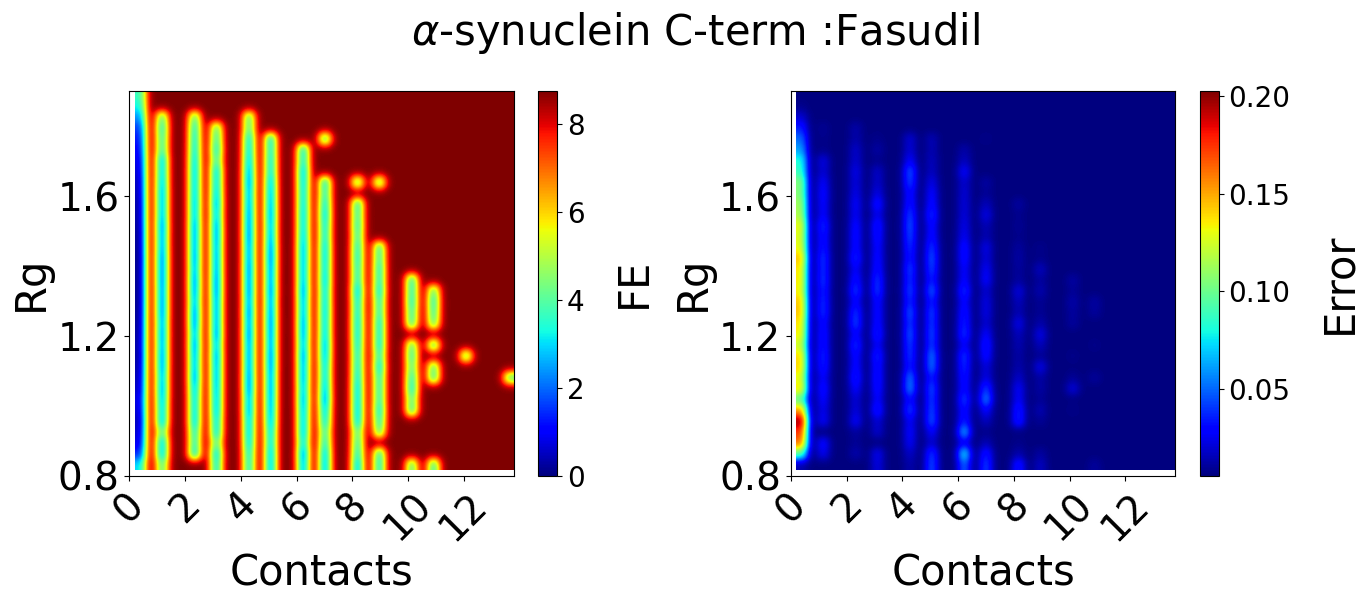

In [241]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
ax=axes.flat

s1 = ax[0].imshow(fe, cmap='jet', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
            interpolation='gaussian')
cbar = fig.colorbar(s1, ax=ax[0])
cbar.set_label("FE", size=30, labelpad=20)
cbar.ax.tick_params(labelsize=20)

ax[0].tick_params(labelsize=28)
ax[0].set_ylabel('Rg', size=30)
ax[0].set_xlabel('Contacts', size=30)

ax[0].set_xticks(np.arange(Y.min(), Y.max(), 2), np.arange(Y.min(), Y.max(), 2), rotation=45)
ax[0].set_yticks(np.arange(X.min(), X.max(), 0.4), [round(i, 1) for i in np.arange(X.min(), X.max(), 0.4)], rotation=0)
ax[0].grid(False)
# ax[0].set_title(r'$\alpha$-synuclein C-term :Fasudil',size=30, pad=15)

s2 = ax[1].imshow(np.flip(adjust_min(err), 0), cmap='jet', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
            interpolation='gaussian')
# plt.colorbar(s2, ax=ax[1], label="Error")
cbar = fig.colorbar(s2, ax=ax[1])
cbar.set_label("Error", size=30, labelpad=20)
cbar.ax.tick_params(labelsize=20)

ax[1].tick_params(labelsize=28)
ax[1].set_ylabel('Rg', size=30)
ax[1].set_xlabel('Contacts', size=30)

ax[1].set_xticks(np.arange(Y.min(), Y.max(), 2), np.arange(Y.min(), Y.max(), 2), rotation=45)
ax[1].set_yticks(np.arange(X.min(), X.max(), 0.4), [round(i, 1) for i in np.arange(X.min(), X.max(), 0.4)], rotation=0)
ax[1].grid(False)

plt.suptitle(r'$\alpha$-synuclein C-term :Fasudil',size=30, y=1.0)

plt.tight_layout()

In [242]:
bins=2

_, xedges, yedges = np.histogram2d(x=X, y=Y, bins=bins, range=[[X.min(), X.max()], [Y.min(), Y.max()]], density=True)

rg_bor, lc_bor = xedges , yedges
print(rg_bor, lc_bor)

[0.78287311 1.34143954 1.90000597] [ 0.  7. 14.]


In [243]:
q1_1d=np.zeros(len(X))
q2_1d=np.zeros(len(X))
q3_1d=np.zeros(len(X))
q4_1d=np.zeros(len(X))
index=0

for rg,lc in zip(X,Y):

    if rg_bor[0]<=rg<=rg_bor[1] and lc_bor[0]<=lc<=lc_bor[1]: q1_1d[index]=1
    else : q1_1d[index]=0

    if rg_bor[1]<rg<=rg_bor[2] and lc_bor[0]<=lc<=lc_bor[1]: q2_1d[index]=1
    else : q2_1d[index]=0

    if rg_bor[1]<rg<=rg_bor[2] and lc_bor[1]<lc<=lc_bor[2]: q3_1d[index]=1
    else : q3_1d[index]=0

    if rg_bor[0]<=rg<=rg_bor[1] and lc_bor[1]<lc<=lc_bor[2]: q4_1d[index]=1
    else : q4_1d[index]=0

    index+=1
    

In [244]:
print(f'Q1 : {round(rg_bor[0],4)} <= rg <= {round(rg_bor[1], 4)} and {round(lc_bor[0], 4)} <= lc <= {round(lc_bor[1], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip(q1_1d)}\n')
print(f'Q2 : {round(rg_bor[1],4)} < rg <= {round(rg_bor[2], 4)} and {round(lc_bor[0], 4)} <= lc <= {round(lc_bor[1], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip(q2_1d)}\n')
print(f'Q3 : {round(rg_bor[1],4)} < rg <= {round(rg_bor[2], 4)} and {round(lc_bor[1], 4)} < lc <= {round(lc_bor[2], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip(q3_1d)}\n')
print(f'Q4 : {round(rg_bor[0],4)} <= rg <= {round(rg_bor[1], 4)} and {round(lc_bor[1], 4)} < lc <= {round(lc_bor[2], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip(q4_1d)}\n')


Q1 : 0.7829 <= rg <= 1.3414 and 0.0 <= lc <= 7.0 : 
Prob, B_err : (0.5557022368903557, 0.020328383262856208)

Q2 : 1.3414 < rg <= 1.9 and 0.0 <= lc <= 7.0 : 
Prob, B_err : (0.4222222222222222, 0.028196165799443132)

Q3 : 1.3414 < rg <= 1.9 and 7.0 < lc <= 14.0 : 
Prob, B_err : (0.002566923359002567, 0.0006789010775627619)

Q4 : 0.7829 <= rg <= 1.3414 and 7.0 < lc <= 14.0 : 
Prob, B_err : (0.01950861752841951, 0.004229486460335693)



## ssREST3 protein+Fasudil (16 replicas)

In [245]:
data_dir='/Volumes/128JK/work/REST_DATA/ssREST3/'
req_dir='data_fas_16'

rg=load_json(f'{data_dir}/{req_dir}/rg.json')
# sa=load_json(f'{data_dir}/{req_dir}/sa.json')
cm=load_json(f'{data_dir}/{req_dir}/contact_matrix.json')

# xvg_temp=np.loadtxt(f'{data_dir}/{req_dir}/replica_temp.xvg',comments=['#','@'])
# xvg_index=np.loadtxt(f'{data_dir}/{req_dir}/replica_index.xvg',comments=['#','@'])


In [246]:
X=np.array(rg['rep:0']) # appears on Y axis
Y=np.sum(cm['rep:0'], 1) # appears on X axis

assert X.shape[0]==Y.shape[0], "Shapes are not matching"

data=np.stack([X,Y])

Text(0.5, 1.0, '$\\alpha$-synuclein C-term :Fasudil')

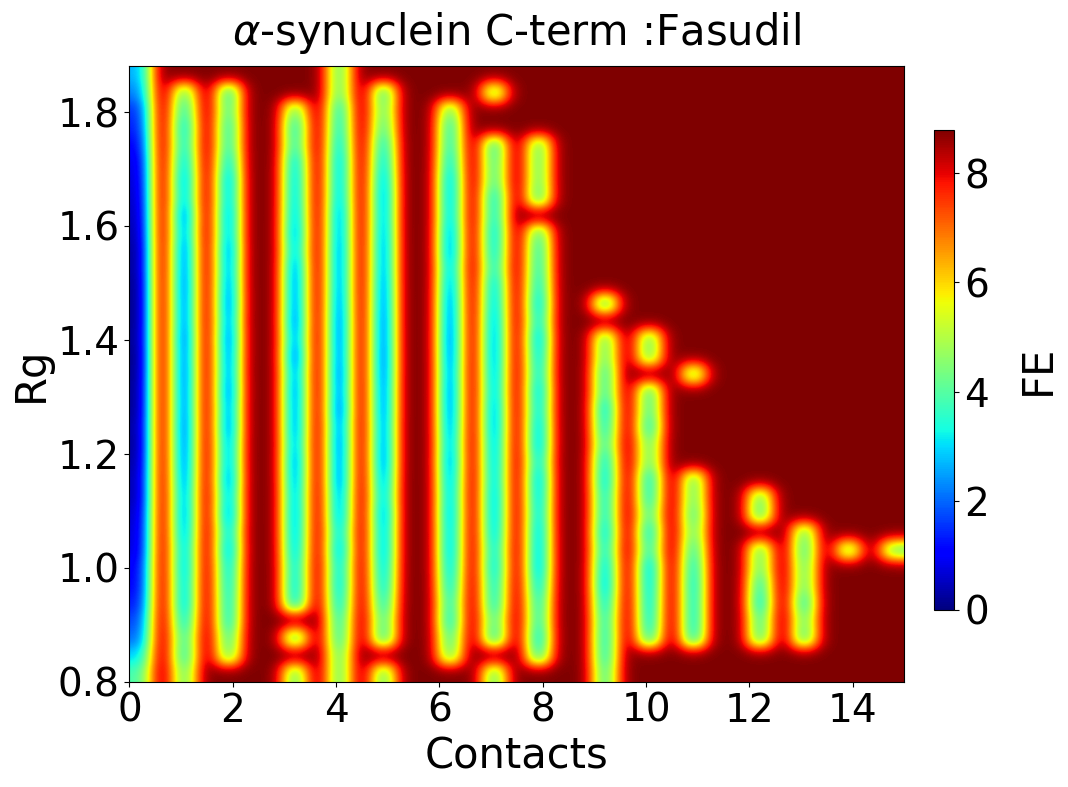

In [247]:
T=300
bins=35

# range=[[X.min()-0.2, X.max()+0.2], [Y.min()-2, Y.max()+2]]
# range=[[0.5, 2.25], [0, 17]]
range=[[X.min(), X.max()], [Y.min(), Y.max()]]

histo, xedges, yedges = np.histogram2d(x=X, y=Y, bins=bins, 
                                       range=range, 
                                       density=True)

xcenters = xedges[:-1] + np.diff(xedges)/2
ycenters = yedges[:-1] + np.diff(yedges)/2

free_energy = np.log(np.flipud(histo) + 0.000001)
free_energy = -(0.001987 * T) * free_energy
free_energy = free_energy-np.min(free_energy)

images=[]

fig, axes = plt.subplots(1, 1, figsize=(10,8))
cax= fig.add_axes([0.93, 0.2, 0.02, 0.6])

im = axes.imshow(free_energy, cmap='jet', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
            interpolation='gaussian')

images.append(im)
cbar = fig.colorbar(images[-1],cax=cax)
cbar.set_label("FE", size=30, labelpad=20)
cbar.ax.tick_params(labelsize=28)

axes.tick_params(labelsize=28)
axes.set_ylabel('Rg', size=30)
axes.set_xlabel('Contacts', size=30)

axes.set_xticks(np.arange(Y.min(), Y.max(), 2), np.arange(Y.min(), Y.max(), 2), rotation=0)
axes.set_yticks(np.arange(X.min(), X.max(), 0.2), [round(i, 1) for i in np.arange(X.min(), X.max(), 0.2)], rotation=0)
axes.grid(False)
axes.set_title(r'$\alpha$-synuclein C-term :Fasudil',size=30, pad=15)

In [248]:
fe, xedges,yedges, ferr, err = free_energy_2D_blockerror(Y=X, X=Y, bins=35, T=300, y0=X.min(), ymax=X.max(),
                                                        x0=Y.min(), xmax=Y.max(), weights=None, blocks=500)


/var/folders/s4/rkgttpts2xl9drlltn1361m00000gn/T/ipykernel_15336/4038208200.py:39: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)


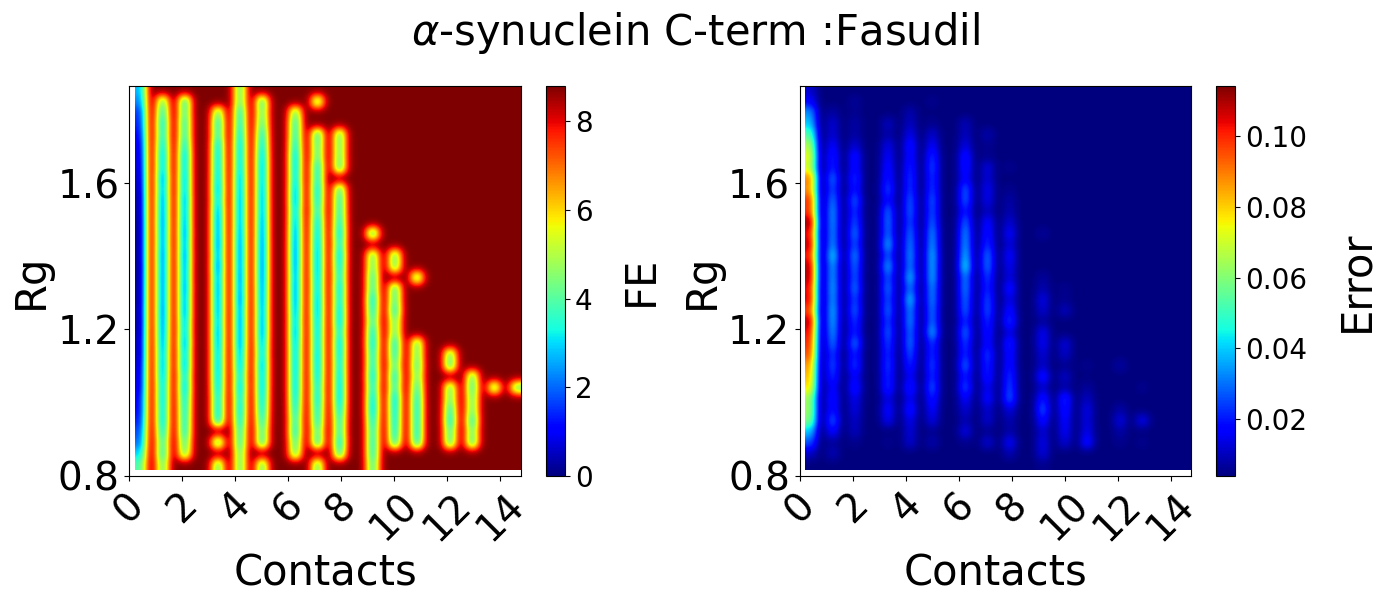

In [249]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
ax=axes.flat

s1 = ax[0].imshow(fe, cmap='jet', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
            interpolation='gaussian')
cbar = fig.colorbar(s1, ax=ax[0])
cbar.set_label("FE", size=30, labelpad=20)
cbar.ax.tick_params(labelsize=20)

ax[0].tick_params(labelsize=28)
ax[0].set_ylabel('Rg', size=30)
ax[0].set_xlabel('Contacts', size=30)

ax[0].set_xticks(np.arange(Y.min(), Y.max(), 2), np.arange(Y.min(), Y.max(), 2), rotation=45)
ax[0].set_yticks(np.arange(X.min(), X.max(), 0.4), [round(i, 1) for i in np.arange(X.min(), X.max(), 0.4)], rotation=0)
ax[0].grid(False)
# ax[0].set_title(r'$\alpha$-synuclein C-term :Fasudil',size=30, pad=15)

s2 = ax[1].imshow(np.flip(adjust_min(err), 0), cmap='jet', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
            interpolation='gaussian')
# plt.colorbar(s2, ax=ax[1], label="Error")
cbar = fig.colorbar(s2, ax=ax[1])
cbar.set_label("Error", size=30, labelpad=20)
cbar.ax.tick_params(labelsize=20)

ax[1].tick_params(labelsize=28)
ax[1].set_ylabel('Rg', size=30)
ax[1].set_xlabel('Contacts', size=30)

ax[1].set_xticks(np.arange(Y.min(), Y.max(), 2), np.arange(Y.min(), Y.max(), 2), rotation=45)
ax[1].set_yticks(np.arange(X.min(), X.max(), 0.4), [round(i, 1) for i in np.arange(X.min(), X.max(), 0.4)], rotation=0)
ax[1].grid(False)

plt.suptitle(r'$\alpha$-synuclein C-term :Fasudil',size=30, y=1.0)

plt.tight_layout()

In [250]:
bins=2

_, xedges, yedges = np.histogram2d(x=X, y=Y, bins=bins, range=[[X.min(), X.max()], [Y.min(), Y.max()]], density=True)

rg_bor, lc_bor = xedges , yedges
print(rg_bor, lc_bor)

[0.78979446 1.33033146 1.87086846] [ 0.   7.5 15. ]


In [251]:
q1_1d=np.zeros(len(X))
q2_1d=np.zeros(len(X))
q3_1d=np.zeros(len(X))
q4_1d=np.zeros(len(X))
index=0

for rg,lc in zip(X,Y):

    if rg_bor[0]<=rg<=rg_bor[1] and lc_bor[0]<=lc<=lc_bor[1]: q1_1d[index]=1
    else : q1_1d[index]=0

    if rg_bor[1]<rg<=rg_bor[2] and lc_bor[0]<=lc<=lc_bor[1]: q2_1d[index]=1
    else : q2_1d[index]=0

    if rg_bor[1]<rg<=rg_bor[2] and lc_bor[1]<lc<=lc_bor[2]: q3_1d[index]=1
    else : q3_1d[index]=0

    if rg_bor[0]<=rg<=rg_bor[1] and lc_bor[1]<lc<=lc_bor[2]: q4_1d[index]=1
    else : q4_1d[index]=0

    index+=1
    

In [252]:
print(f'Q1 : {round(rg_bor[0],4)} <= rg <= {round(rg_bor[1], 4)} and {round(lc_bor[0], 4)} <= lc <= {round(lc_bor[1], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip(q1_1d)}\n')
print(f'Q2 : {round(rg_bor[1],4)} < rg <= {round(rg_bor[2], 4)} and {round(lc_bor[0], 4)} <= lc <= {round(lc_bor[1], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip(q2_1d)}\n')
print(f'Q3 : {round(rg_bor[1],4)} < rg <= {round(rg_bor[2], 4)} and {round(lc_bor[1], 4)} < lc <= {round(lc_bor[2], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip(q3_1d)}\n')
print(f'Q4 : {round(rg_bor[0],4)} <= rg <= {round(rg_bor[1], 4)} and {round(lc_bor[1], 4)} < lc <= {round(lc_bor[2], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip(q4_1d)}\n')


Q1 : 0.7898 <= rg <= 1.3303 and 0.0 <= lc <= 7.5 : 
Prob, B_err : (0.4388683615507638, 0.00967018193735475)

Q2 : 1.3303 < rg <= 1.8709 and 0.0 <= lc <= 7.5 : 
Prob, B_err : (0.5236860971709039, 0.012538090291772976)

Q3 : 1.3303 < rg <= 1.8709 and 7.5 < lc <= 15.0 : 
Prob, B_err : (0.005294214967186897, 0.0009837476425151287)

Q4 : 0.7898 <= rg <= 1.3303 and 7.5 < lc <= 15.0 : 
Prob, B_err : (0.03215132631114542, 0.006993712952576242)



## ssREST3 protein+Ligand 47(8 replicas)

In [253]:
data_dir='/Volumes/128JK/work/REST_DATA/ssREST3/'
req_dir='data_lig47_8'

rg=load_json(f'{data_dir}/{req_dir}/rg.json')
# sa=load_json(f'{data_dir}/{req_dir}/sa.json')
cm=load_json(f'{data_dir}/{req_dir}/contact_matrix.json')

# xvg_temp=np.loadtxt(f'{data_dir}/{req_dir}/replica_temp.xvg',comments=['#','@'])
# xvg_index=np.loadtxt(f'{data_dir}/{req_dir}/replica_index.xvg',comments=['#','@'])


In [254]:
X=np.array(rg['rep:0']) # appears on Y axis
Y=np.sum(cm['rep:0'], 1) # appears on X axis

assert X.shape[0]==Y.shape[0], "Shapes are not matching"

data=np.stack([X,Y])

Text(0.5, 1.0, '$\\alpha$-synuclein C-term :Ligand 47')

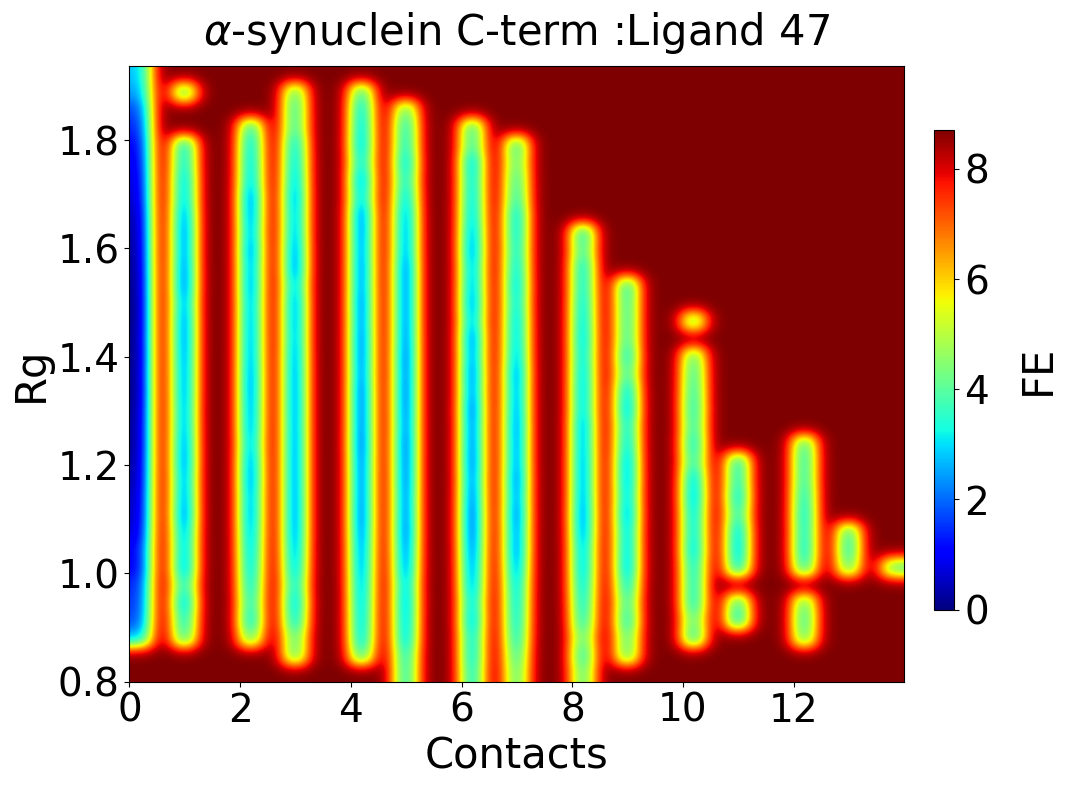

In [255]:
T=300
bins=35

# range=[[X.min()-0.2, X.max()+0.2], [Y.min()-2, Y.max()+2]]
# range=[[0.5, 2.25], [0, 17]]
range=[[X.min(), X.max()], [Y.min(), Y.max()]]

histo, xedges, yedges = np.histogram2d(x=X, y=Y, bins=bins, 
                                       range=range, 
                                       density=True)

xcenters = xedges[:-1] + np.diff(xedges)/2
ycenters = yedges[:-1] + np.diff(yedges)/2

free_energy = np.log(np.flipud(histo) + 0.000001)
free_energy = -(0.001987 * T) * free_energy
free_energy = free_energy-np.min(free_energy)

images=[]

fig, axes = plt.subplots(1, 1, figsize=(10,8))
cax= fig.add_axes([0.93, 0.2, 0.02, 0.6])

im = axes.imshow(free_energy, cmap='jet', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
            interpolation='gaussian')

images.append(im)
cbar = fig.colorbar(images[-1],cax=cax)
cbar.set_label("FE", size=30, labelpad=20)
cbar.ax.tick_params(labelsize=28)

axes.tick_params(labelsize=28)
axes.set_ylabel('Rg', size=30)
axes.set_xlabel('Contacts', size=30)

axes.set_xticks(np.arange(Y.min(), Y.max(), 2), np.arange(Y.min(), Y.max(), 2), rotation=0)
axes.set_yticks(np.arange(X.min(), X.max(), 0.2), [round(i, 1) for i in np.arange(X.min(), X.max(), 0.2)], rotation=0)
axes.grid(False)
axes.set_title(r'$\alpha$-synuclein C-term :Ligand 47',size=30, pad=15)

In [256]:
fe, xedges,yedges, ferr, err = free_energy_2D_blockerror(Y=X, X=Y, bins=35, T=300, y0=X.min(), ymax=X.max(),
                                                        x0=Y.min(), xmax=Y.max(), weights=None, blocks=500)


/var/folders/s4/rkgttpts2xl9drlltn1361m00000gn/T/ipykernel_15336/4038208200.py:39: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)


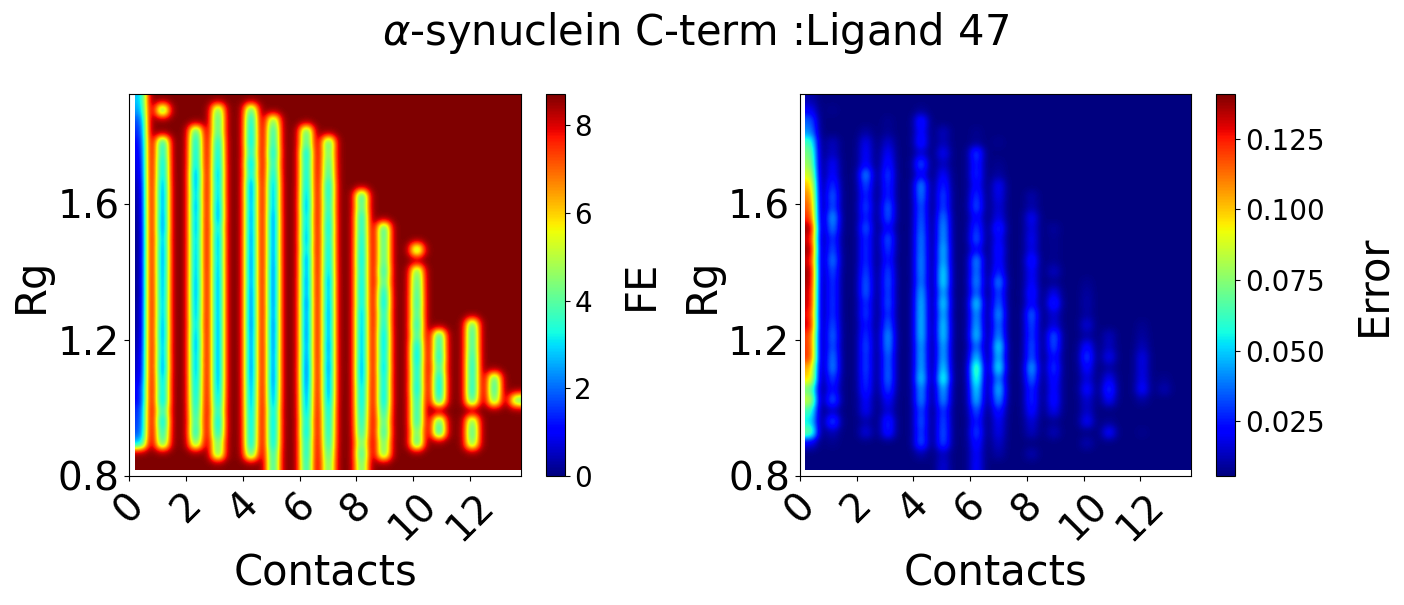

In [257]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
ax=axes.flat

s1 = ax[0].imshow(fe, cmap='jet', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
            interpolation='gaussian')
cbar = fig.colorbar(s1, ax=ax[0])
cbar.set_label("FE", size=30, labelpad=20)
cbar.ax.tick_params(labelsize=20)

ax[0].tick_params(labelsize=28)
ax[0].set_ylabel('Rg', size=30)
ax[0].set_xlabel('Contacts', size=30)

ax[0].set_xticks(np.arange(Y.min(), Y.max(), 2), np.arange(Y.min(), Y.max(), 2), rotation=45)
ax[0].set_yticks(np.arange(X.min(), X.max(), 0.4), [round(i, 1) for i in np.arange(X.min(), X.max(), 0.4)], rotation=0)
ax[0].grid(False)
# ax[0].set_title(r'$\alpha$-synuclein C-term :Fasudil',size=30, pad=15)

s2 = ax[1].imshow(np.flip(adjust_min(err), 0), cmap='jet', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
            interpolation='gaussian')
# plt.colorbar(s2, ax=ax[1], label="Error")
cbar = fig.colorbar(s2, ax=ax[1])
cbar.set_label("Error", size=30, labelpad=20)
cbar.ax.tick_params(labelsize=20)

ax[1].tick_params(labelsize=28)
ax[1].set_ylabel('Rg', size=30)
ax[1].set_xlabel('Contacts', size=30)

ax[1].set_xticks(np.arange(Y.min(), Y.max(), 2), np.arange(Y.min(), Y.max(), 2), rotation=45)
ax[1].set_yticks(np.arange(X.min(), X.max(), 0.4), [round(i, 1) for i in np.arange(X.min(), X.max(), 0.4)], rotation=0)
ax[1].grid(False)

plt.suptitle(r'$\alpha$-synuclein C-term :Ligand 47',size=30, y=1.0)

plt.tight_layout()

In [258]:
bins=2

_, xedges, yedges = np.histogram2d(x=X, y=Y, bins=bins, range=[[X.min(), X.max()], [Y.min(), Y.max()]], density=True)

rg_bor, lc_bor = xedges , yedges
print(rg_bor, lc_bor)

[0.76756649 1.33620681 1.90484713] [ 0.  7. 14.]


In [259]:
q1_1d=np.zeros(len(X))
q2_1d=np.zeros(len(X))
q3_1d=np.zeros(len(X))
q4_1d=np.zeros(len(X))
index=0

for rg,lc in zip(X,Y):

    if rg_bor[0]<=rg<=rg_bor[1] and lc_bor[0]<=lc<=lc_bor[1]: q1_1d[index]=1
    else : q1_1d[index]=0

    if rg_bor[1]<rg<=rg_bor[2] and lc_bor[0]<=lc<=lc_bor[1]: q2_1d[index]=1
    else : q2_1d[index]=0

    if rg_bor[1]<rg<=rg_bor[2] and lc_bor[1]<lc<=lc_bor[2]: q3_1d[index]=1
    else : q3_1d[index]=0

    if rg_bor[0]<=rg<=rg_bor[1] and lc_bor[1]<lc<=lc_bor[2]: q4_1d[index]=1
    else : q4_1d[index]=0

    index+=1
    

In [260]:
print(f'Q1 : {round(rg_bor[0],4)} <= rg <= {round(rg_bor[1], 4)} and {round(lc_bor[0], 4)} <= lc <= {round(lc_bor[1], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip(q1_1d)}\n')
print(f'Q2 : {round(rg_bor[1],4)} < rg <= {round(rg_bor[2], 4)} and {round(lc_bor[0], 4)} <= lc <= {round(lc_bor[1], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip(q2_1d)}\n')
print(f'Q3 : {round(rg_bor[1],4)} < rg <= {round(rg_bor[2], 4)} and {round(lc_bor[1], 4)} < lc <= {round(lc_bor[2], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip(q3_1d)}\n')
print(f'Q4 : {round(rg_bor[0],4)} <= rg <= {round(rg_bor[1], 4)} and {round(lc_bor[1], 4)} < lc <= {round(lc_bor[2], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip(q4_1d)}\n')


Q1 : 0.7676 <= rg <= 1.3362 and 0.0 <= lc <= 7.0 : 
Prob, B_err : (0.4786836200448766, 0.02083002248485393)

Q2 : 1.3362 < rg <= 1.9048 and 0.0 <= lc <= 7.0 : 
Prob, B_err : (0.46133133881824984, 0.027009932878549667)

Q3 : 1.3362 < rg <= 1.9048 and 7.0 < lc <= 14.0 : 
Prob, B_err : (0.007105459985041137, 0.0022672871771151123)

Q4 : 0.7676 <= rg <= 1.3362 and 7.0 < lc <= 14.0 : 
Prob, B_err : (0.05287958115183246, 0.01074965489847886)



## ssREST3 protein+Ligand 47 (16 replicas)

In [261]:
data_dir='/Volumes/128JK/work/REST_DATA/ssREST3/'
req_dir='data_lig47_16'

rg=load_json(f'{data_dir}/{req_dir}/rg.json')
# sa=load_json(f'{data_dir}/{req_dir}/sa.json')
cm=load_json(f'{data_dir}/{req_dir}/contact_matrix.json')

# xvg_temp=np.loadtxt(f'{data_dir}/{req_dir}/replica_temp.xvg',comments=['#','@'])
# xvg_index=np.loadtxt(f'{data_dir}/{req_dir}/replica_index.xvg',comments=['#','@'])


In [262]:
X=np.array(rg['rep:0']) # appears on Y axis
Y=np.sum(cm['rep:0'], 1) # appears on X axis

assert X.shape[0]==Y.shape[0], "Shapes are not matching"

data=np.stack([X,Y])

Text(0.5, 1.0, '$\\alpha$-synuclein C-term :Ligand 47')

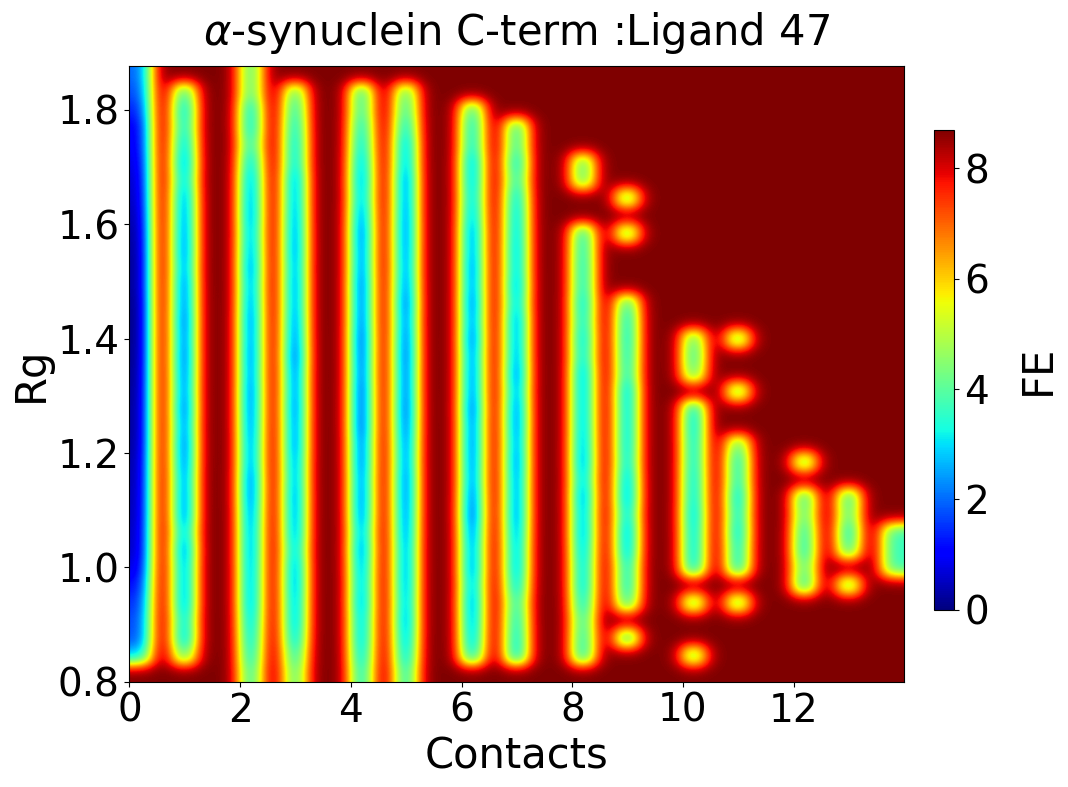

In [263]:
T=300
bins=35

# range=[[X.min()-0.2, X.max()+0.2], [Y.min()-2, Y.max()+2]]
# range=[[0.5, 2.25], [0, 17]]
range=[[X.min(), X.max()], [Y.min(), Y.max()]]

histo, xedges, yedges = np.histogram2d(x=X, y=Y, bins=bins, 
                                       range=range, 
                                       density=True)

xcenters = xedges[:-1] + np.diff(xedges)/2
ycenters = yedges[:-1] + np.diff(yedges)/2

free_energy = np.log(np.flipud(histo) + 0.000001)
free_energy = -(0.001987 * T) * free_energy
free_energy = free_energy-np.min(free_energy)

images=[]

fig, axes = plt.subplots(1, 1, figsize=(10,8))
cax= fig.add_axes([0.93, 0.2, 0.02, 0.6])

im = axes.imshow(free_energy, cmap='jet', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
            interpolation='gaussian')

images.append(im)
cbar = fig.colorbar(images[-1],cax=cax)
cbar.set_label("FE", size=30, labelpad=20)
cbar.ax.tick_params(labelsize=28)

axes.tick_params(labelsize=28)
axes.set_ylabel('Rg', size=30)
axes.set_xlabel('Contacts', size=30)

axes.set_xticks(np.arange(Y.min(), Y.max(), 2), np.arange(Y.min(), Y.max(), 2), rotation=0)
axes.set_yticks(np.arange(X.min(), X.max(), 0.2), [round(i, 1) for i in np.arange(X.min(), X.max(), 0.2)], rotation=0)
axes.grid(False)
axes.set_title(r'$\alpha$-synuclein C-term :Ligand 47',size=30, pad=15)

In [264]:
fe, xedges,yedges, ferr, err = free_energy_2D_blockerror(Y=X, X=Y, bins=35, T=300, y0=X.min(), ymax=X.max(),
                                                        x0=Y.min(), xmax=Y.max(), weights=None, blocks=500)


/var/folders/s4/rkgttpts2xl9drlltn1361m00000gn/T/ipykernel_15336/4038208200.py:39: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)


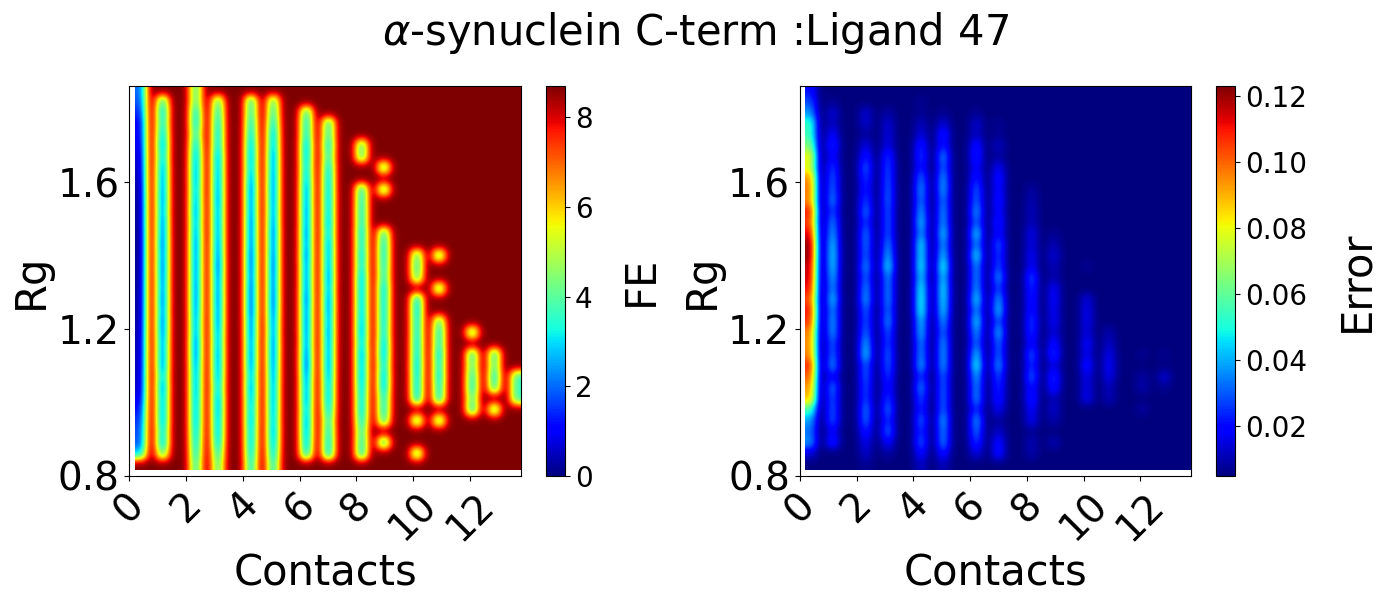

In [265]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
ax=axes.flat

s1 = ax[0].imshow(fe, cmap='jet', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
            interpolation='gaussian')
cbar = fig.colorbar(s1, ax=ax[0])
cbar.set_label("FE", size=30, labelpad=20)
cbar.ax.tick_params(labelsize=20)

ax[0].tick_params(labelsize=28)
ax[0].set_ylabel('Rg', size=30)
ax[0].set_xlabel('Contacts', size=30)

ax[0].set_xticks(np.arange(Y.min(), Y.max(), 2), np.arange(Y.min(), Y.max(), 2), rotation=45)
ax[0].set_yticks(np.arange(X.min(), X.max(), 0.4), [round(i, 1) for i in np.arange(X.min(), X.max(), 0.4)], rotation=0)
ax[0].grid(False)
# ax[0].set_title(r'$\alpha$-synuclein C-term :Fasudil',size=30, pad=15)

s2 = ax[1].imshow(np.flip(adjust_min(err), 0), cmap='jet', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
            interpolation='gaussian')
# plt.colorbar(s2, ax=ax[1], label="Error")
cbar = fig.colorbar(s2, ax=ax[1])
cbar.set_label("Error", size=30, labelpad=20)
cbar.ax.tick_params(labelsize=20)

ax[1].tick_params(labelsize=28)
ax[1].set_ylabel('Rg', size=30)
ax[1].set_xlabel('Contacts', size=30)

ax[1].set_xticks(np.arange(Y.min(), Y.max(), 2), np.arange(Y.min(), Y.max(), 2), rotation=45)
ax[1].set_yticks(np.arange(X.min(), X.max(), 0.4), [round(i, 1) for i in np.arange(X.min(), X.max(), 0.4)], rotation=0)
ax[1].grid(False)

plt.suptitle(r'$\alpha$-synuclein C-term :Ligand 47',size=30, y=1.0)

plt.tight_layout()

In [266]:
bins=2

_, xedges, yedges = np.histogram2d(x=X, y=Y, bins=bins, range=[[X.min(), X.max()], [Y.min(), Y.max()]], density=True)

rg_bor, lc_bor = xedges , yedges
print(rg_bor, lc_bor)

[0.78903919 1.32764035 1.86624152] [ 0.  7. 14.]


In [267]:
q1_1d=np.zeros(len(X))
q2_1d=np.zeros(len(X))
q3_1d=np.zeros(len(X))
q4_1d=np.zeros(len(X))
index=0

for rg,lc in zip(X,Y):

    if rg_bor[0]<=rg<=rg_bor[1] and lc_bor[0]<=lc<=lc_bor[1]: q1_1d[index]=1
    else : q1_1d[index]=0

    if rg_bor[1]<rg<=rg_bor[2] and lc_bor[0]<=lc<=lc_bor[1]: q2_1d[index]=1
    else : q2_1d[index]=0

    if rg_bor[1]<rg<=rg_bor[2] and lc_bor[1]<lc<=lc_bor[2]: q3_1d[index]=1
    else : q3_1d[index]=0

    if rg_bor[0]<=rg<=rg_bor[1] and lc_bor[1]<lc<=lc_bor[2]: q4_1d[index]=1
    else : q4_1d[index]=0

    index+=1
    

In [268]:
print(f'Q1 : {round(rg_bor[0],4)} <= rg <= {round(rg_bor[1], 4)} and {round(lc_bor[0], 4)} <= lc <= {round(lc_bor[1], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip(q1_1d)}\n')
print(f'Q2 : {round(rg_bor[1],4)} < rg <= {round(rg_bor[2], 4)} and {round(lc_bor[0], 4)} <= lc <= {round(lc_bor[1], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip(q2_1d)}\n')
print(f'Q3 : {round(rg_bor[1],4)} < rg <= {round(rg_bor[2], 4)} and {round(lc_bor[1], 4)} < lc <= {round(lc_bor[2], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip(q3_1d)}\n')
print(f'Q4 : {round(rg_bor[0],4)} <= rg <= {round(rg_bor[1], 4)} and {round(lc_bor[1], 4)} < lc <= {round(lc_bor[2], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip(q4_1d)}\n')


Q1 : 0.789 <= rg <= 1.3276 and 0.0 <= lc <= 7.0 : 
Prob, B_err : (0.4653567071212997, 0.011001581101325777)

Q2 : 1.3276 < rg <= 1.8662 and 0.0 <= lc <= 7.0 : 
Prob, B_err : (0.4908495472933924, 0.015659665377186674)

Q3 : 1.3276 < rg <= 1.8662 and 7.0 < lc <= 14.0 : 
Prob, B_err : (0.005715019585179477, 0.0009652144572550186)

Q4 : 0.789 <= rg <= 1.3276 and 7.0 < lc <= 14.0 : 
Prob, B_err : (0.038078726000128425, 0.006086686352753028)



## PBMeta-D protein+Fasudil (1)

In [269]:
index_dict={
    'Rg':1, 'H-bond':2, 'Helix-right':3, 'Betasheet':4, 'Helix-left':5, 'Polypro':6,
    'Dist-1':7, 'Dist-2':8, 'Dist-3':9, 'Dist-4':10, 'Dist-5':11, 'Dist-6':12
       }

In [270]:
PB_dir = '/Users/jayakrishnakoneru/Documents/work/plots_now/PBMetaD/'
req_dir = 'fas_1'

colvar_data = np.loadtxt(f'{PB_dir}/{req_dir}/colvar/colvar_0.dat', comments=['#', '@'])
num_cvs, _, weights_norm = norm_weights(f'{PB_dir}/{req_dir}/colvar/colvar_0.dat')

print(f"Sum of combined xtc weights : {np.sum(weights_norm)}")
print(f"Number of frames : {colvar_data.shape[0]}")

Sum of combined xtc weights : 1.0
Number of frames : 1600001


In [271]:
file_name = 'contact_matrix.json'
cm = load_json(f'{PB_dir}/{req_dir}/data/out_0/{file_name}')

In [272]:
X=colvar_data.T[index_dict['Rg']] # appears on Y axis
Y=np.sum(cm['0'], axis=1) # appears on X axis

assert X.shape[0]==Y.shape[0], "Shapes are not matching"

data=np.stack([X,Y])

Text(0.5, 1.0, '$\\alpha$-synuclein C-term :Fasudil')

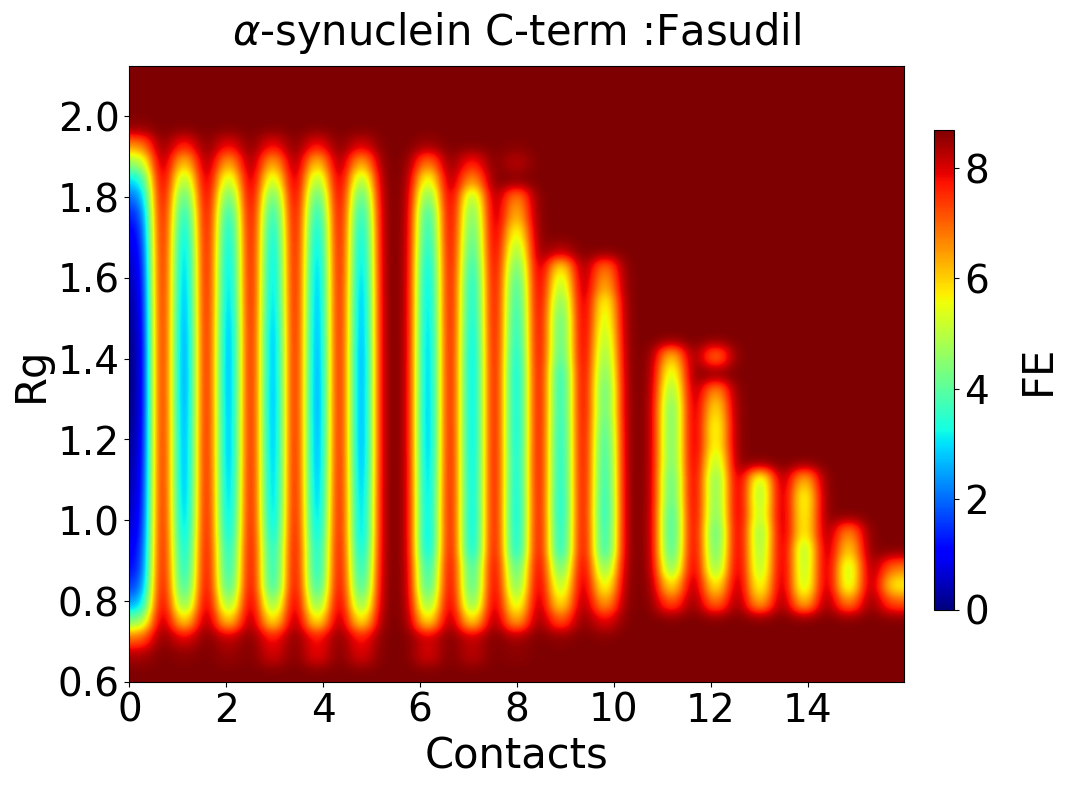

In [273]:
T=300
bins=35

# range=[[X.min()-0.2, X.max()+0.2], [Y.min()-2, Y.max()+2]]
# range=[[0.5, 2.25], [0, 17]]
range=[[X.min(), X.max()], [Y.min(), Y.max()]]

histo, xedges, yedges = np.histogram2d(x=X, y=Y, bins=bins, 
                                       range=range, 
                                       density=True,
                                       weights=weights_norm)

xcenters = xedges[:-1] + np.diff(xedges)/2
ycenters = yedges[:-1] + np.diff(yedges)/2

free_energy = np.log(np.flipud(histo) + 0.000001)
free_energy = -(0.001987 * T) * free_energy
free_energy = free_energy-np.min(free_energy)

images=[]

fig, axes = plt.subplots(1, 1, figsize=(10,8))
cax= fig.add_axes([0.93, 0.2, 0.02, 0.6])

im = axes.imshow(free_energy, cmap='jet', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
            interpolation='gaussian')

images.append(im)
cbar = fig.colorbar(images[-1],cax=cax)
cbar.set_label("FE", size=30, labelpad=20)
cbar.ax.tick_params(labelsize=28)

axes.tick_params(labelsize=28)
axes.set_ylabel('Rg', size=30)
axes.set_xlabel('Contacts', size=30)

axes.set_xticks(np.arange(Y.min(), Y.max(), 2), np.arange(Y.min(), Y.max(), 2), rotation=0)
axes.set_yticks(np.arange(X.min(), X.max(), 0.2), [round(i, 1) for i in np.arange(X.min(), X.max(), 0.2)], rotation=0)
axes.grid(False)
axes.set_title(r'$\alpha$-synuclein C-term :Fasudil',size=30, pad=15)

In [274]:
fe, xedges,yedges, ferr, err = free_energy_2D_blockerror(Y=X, X=Y, bins=35, T=300, y0=X.min(), ymax=X.max(),
                                                        x0=Y.min(), xmax=Y.max(), weights=weights_norm, blocks=400)

/var/folders/s4/rkgttpts2xl9drlltn1361m00000gn/T/ipykernel_15336/4038208200.py:39: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)


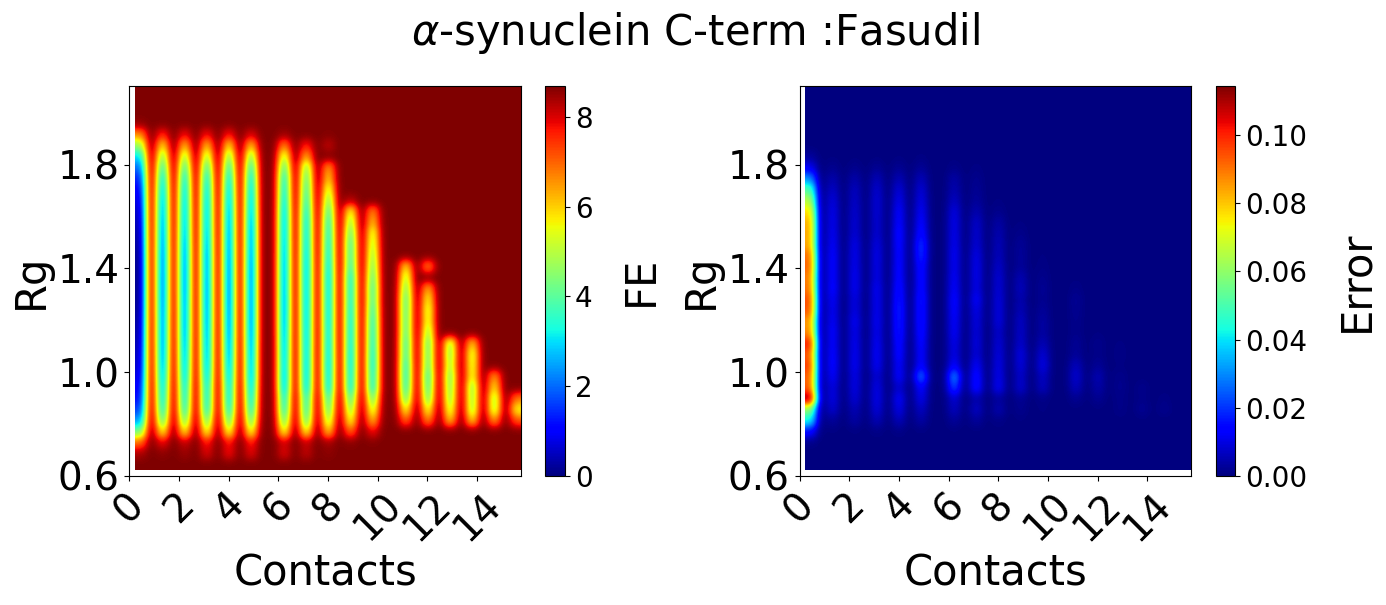

In [275]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
ax=axes.flat

s1 = ax[0].imshow(fe, cmap='jet', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
            interpolation='gaussian')
cbar = fig.colorbar(s1, ax=ax[0])
cbar.set_label("FE", size=30, labelpad=20)
cbar.ax.tick_params(labelsize=20)

ax[0].tick_params(labelsize=28)
ax[0].set_ylabel('Rg', size=30)
ax[0].set_xlabel('Contacts', size=30)

ax[0].set_xticks(np.arange(Y.min(), Y.max(), 2), np.arange(Y.min(), Y.max(), 2), rotation=45)
ax[0].set_yticks(np.arange(X.min(), X.max(), 0.4), [round(i, 1) for i in np.arange(X.min(), X.max(), 0.4)], rotation=0)
ax[0].grid(False)
# ax[0].set_title(r'$\alpha$-synuclein C-term :Fasudil',size=30, pad=15)

s2 = ax[1].imshow(np.flip(adjust_min(err), 0), cmap='jet', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
            interpolation='gaussian')
# plt.colorbar(s2, ax=ax[1], label="Error")
cbar = fig.colorbar(s2, ax=ax[1])
cbar.set_label("Error", size=30, labelpad=20)
cbar.ax.tick_params(labelsize=20)

ax[1].tick_params(labelsize=28)
ax[1].set_ylabel('Rg', size=30)
ax[1].set_xlabel('Contacts', size=30)

ax[1].set_xticks(np.arange(Y.min(), Y.max(), 2), np.arange(Y.min(), Y.max(), 2), rotation=45)
ax[1].set_yticks(np.arange(X.min(), X.max(), 0.4), [round(i, 1) for i in np.arange(X.min(), X.max(), 0.4)], rotation=0)
ax[1].grid(False)

plt.suptitle(r'$\alpha$-synuclein C-term :Fasudil',size=30, y=1.0)

plt.tight_layout()

In [276]:
bins=2

_, xedges, yedges = np.histogram2d(x=X, y=Y, bins=bins, range=[[X.min(), X.max()], [Y.min(), Y.max()]], density=True)

rg_bor, lc_bor = xedges , yedges
print(rg_bor, lc_bor)

[0.582306  1.3449445 2.107583 ] [ 0.  8. 16.]


In [277]:
q1_1d=np.zeros(len(X))
q2_1d=np.zeros(len(X))
q3_1d=np.zeros(len(X))
q4_1d=np.zeros(len(X))
index=0

for rg,lc in zip(X,Y):

    if rg_bor[0]<=rg<=rg_bor[1] and lc_bor[0]<=lc<=lc_bor[1]: q1_1d[index]=1
    else : q1_1d[index]=0

    if rg_bor[1]<rg<=rg_bor[2] and lc_bor[0]<=lc<=lc_bor[1]: q2_1d[index]=1
    else : q2_1d[index]=0

    if rg_bor[1]<rg<=rg_bor[2] and lc_bor[1]<lc<=lc_bor[2]: q3_1d[index]=1
    else : q3_1d[index]=0

    if rg_bor[0]<=rg<=rg_bor[1] and lc_bor[1]<lc<=lc_bor[2]: q4_1d[index]=1
    else : q4_1d[index]=0

    index+=1
    

In [278]:
print(f'Q1 : {round(rg_bor[0],4)} <= rg <= {round(rg_bor[1], 4)} and {round(lc_bor[0], 4)} <= lc <= {round(lc_bor[1], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip_rw_(q1_1d, weights=weights_norm)}\n')
print(f'Q2 : {round(rg_bor[1],4)} < rg <= {round(rg_bor[2], 4)} and {round(lc_bor[0], 4)} <= lc <= {round(lc_bor[1], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip_rw_(q2_1d, weights=weights_norm)}\n')
print(f'Q3 : {round(rg_bor[1],4)} < rg <= {round(rg_bor[2], 4)} and {round(lc_bor[1], 4)} < lc <= {round(lc_bor[2], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip_rw_(q3_1d, weights=weights_norm)}\n')
print(f'Q4 : {round(rg_bor[0],4)} <= rg <= {round(rg_bor[1], 4)} and {round(lc_bor[1], 4)} < lc <= {round(lc_bor[2], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip_rw_(q4_1d, weights=weights_norm)}\n')


Q1 : 0.5823 <= rg <= 1.3449 and 0.0 <= lc <= 8.0 : 
Prob, B_err : (0.5628550368266879, 0.019057419771887227)

Q2 : 1.3449 < rg <= 2.1076 and 0.0 <= lc <= 8.0 : 
Prob, B_err : (0.4193717152691776, 0.019845971485947713)

Q3 : 1.3449 < rg <= 2.1076 and 8.0 < lc <= 16.0 : 
Prob, B_err : (0.00125400753356642, 0.00033157964145207595)

Q4 : 0.5823 <= rg <= 1.3449 and 8.0 < lc <= 16.0 : 
Prob, B_err : (0.016519240370567703, 0.0031712727544662574)



## PBMeta-D protein+Fasudil (2)

In [279]:
PB_dir = '/Users/jayakrishnakoneru/Documents/work/plots_now/PBMetaD/'
req_dir = 'fas_2'

colvar_data = np.loadtxt(f'{PB_dir}/{req_dir}/colvar/colvar_0.dat', comments=['#', '@'])
num_cvs, _, weights_norm = norm_weights(f'{PB_dir}/{req_dir}/colvar/colvar_0.dat')

print(f"Sum of combined xtc weights : {np.sum(weights_norm)}")
print(f"Number of frames : {colvar_data.shape[0]}")

Sum of combined xtc weights : 1.0000000000000004
Number of frames : 1600001


In [280]:
file_name = 'contact_matrix.json'
cm = load_json(f'{PB_dir}/{req_dir}/data/out_0/{file_name}')

In [281]:
X=colvar_data.T[index_dict['Rg']] # appears on Y axis
Y=np.sum(cm['0'], axis=1) # appears on X axis

assert X.shape[0]==Y.shape[0], "Shapes are not matching"

data=np.stack([X,Y])

Text(0.5, 1.0, '$\\alpha$-synuclein C-term :Fasudil')

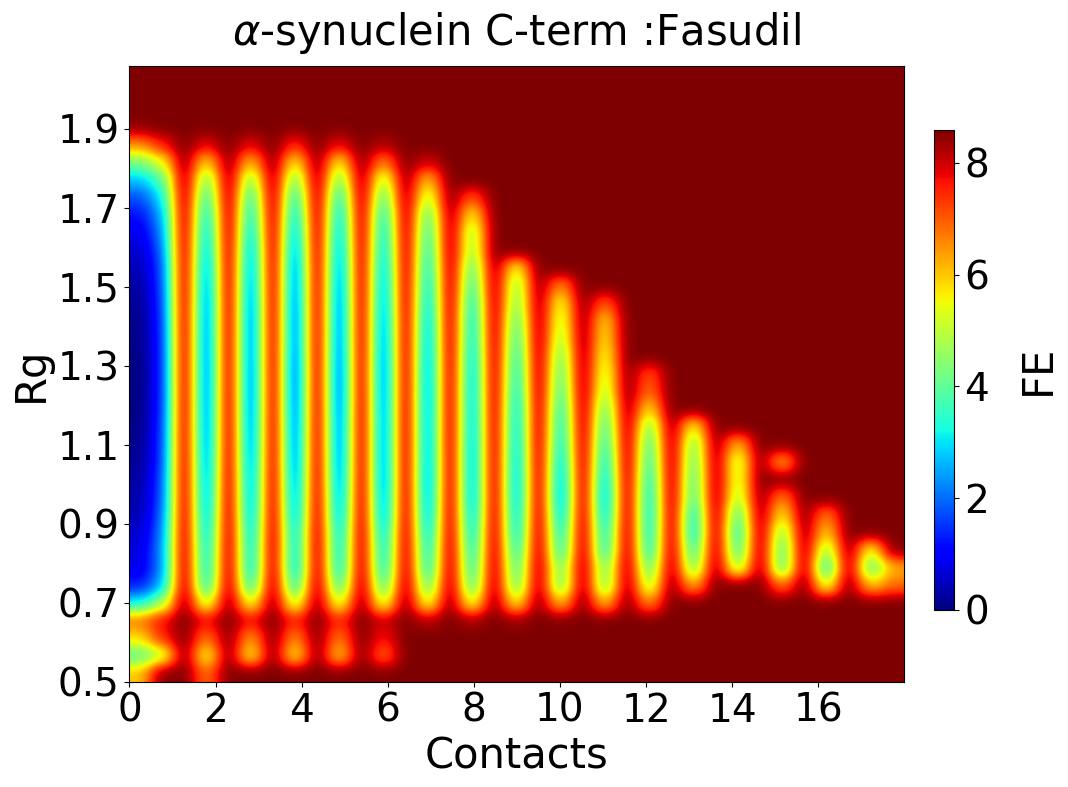

In [282]:
T=300
bins=35

# range=[[X.min()-0.2, X.max()+0.2], [Y.min()-2, Y.max()+2]]
# range=[[0.5, 2.25], [0, 17]]
range=[[X.min(), X.max()], [Y.min(), Y.max()]]

histo, xedges, yedges = np.histogram2d(x=X, y=Y, bins=bins, 
                                       range=range, 
                                       density=True,
                                       weights=weights_norm)

xcenters = xedges[:-1] + np.diff(xedges)/2
ycenters = yedges[:-1] + np.diff(yedges)/2

free_energy = np.log(np.flipud(histo) + 0.000001)
free_energy = -(0.001987 * T) * free_energy
free_energy = free_energy-np.min(free_energy)

images=[]

fig, axes = plt.subplots(1, 1, figsize=(10,8))
cax= fig.add_axes([0.93, 0.2, 0.02, 0.6])

im = axes.imshow(free_energy, cmap='jet', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
            interpolation='gaussian')

images.append(im)
cbar = fig.colorbar(images[-1],cax=cax)
cbar.set_label("FE", size=30, labelpad=20)
cbar.ax.tick_params(labelsize=28)

axes.tick_params(labelsize=28)
axes.set_ylabel('Rg', size=30)
axes.set_xlabel('Contacts', size=30)

axes.set_xticks(np.arange(Y.min(), Y.max(), 2), np.arange(Y.min(), Y.max(), 2), rotation=0)
axes.set_yticks(np.arange(X.min(), X.max(), 0.2), [round(i, 1) for i in np.arange(X.min(), X.max(), 0.2)], rotation=0)
axes.grid(False)
axes.set_title(r'$\alpha$-synuclein C-term :Fasudil',size=30, pad=15)

In [283]:
fe, xedges,yedges, ferr, err = free_energy_2D_blockerror(Y=X, X=Y, bins=35, T=300, y0=X.min(), ymax=X.max(),
                                                        x0=Y.min(), xmax=Y.max(), weights=weights_norm, blocks=400)

/var/folders/s4/rkgttpts2xl9drlltn1361m00000gn/T/ipykernel_15336/4038208200.py:39: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)


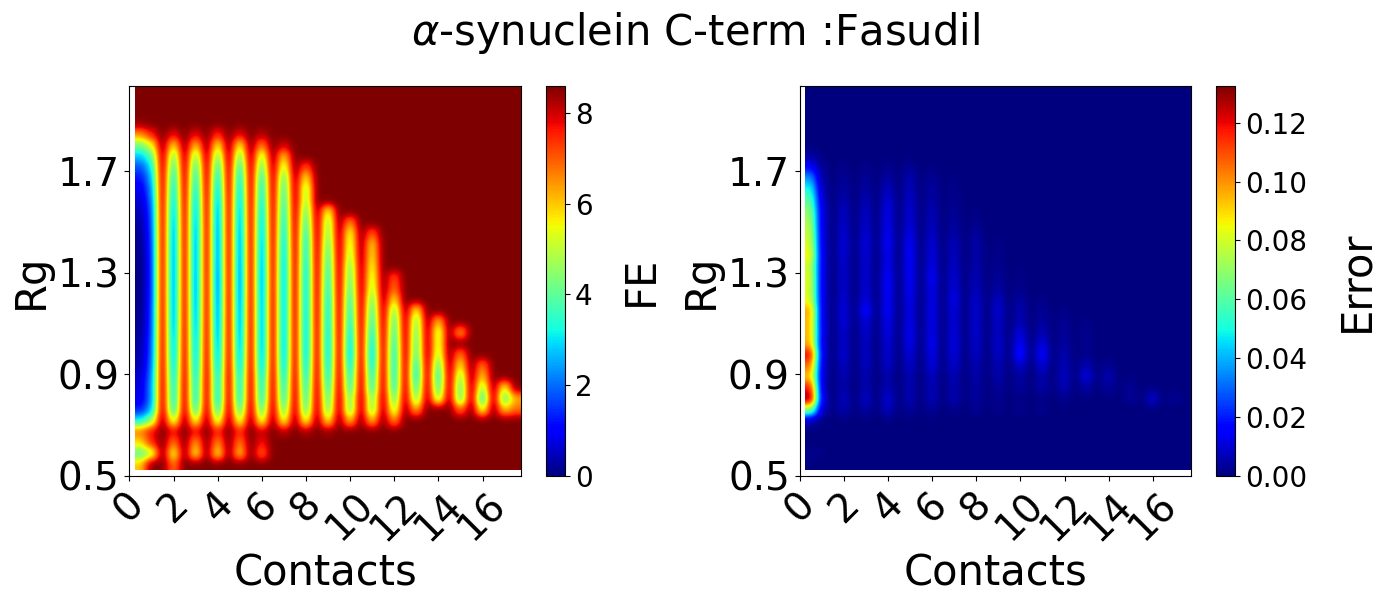

In [284]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
ax=axes.flat

s1 = ax[0].imshow(fe, cmap='jet', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
            interpolation='gaussian')
cbar = fig.colorbar(s1, ax=ax[0])
cbar.set_label("FE", size=30, labelpad=20)
cbar.ax.tick_params(labelsize=20)

ax[0].tick_params(labelsize=28)
ax[0].set_ylabel('Rg', size=30)
ax[0].set_xlabel('Contacts', size=30)

ax[0].set_xticks(np.arange(Y.min(), Y.max(), 2), np.arange(Y.min(), Y.max(), 2), rotation=45)
ax[0].set_yticks(np.arange(X.min(), X.max(), 0.4), [round(i, 1) for i in np.arange(X.min(), X.max(), 0.4)], rotation=0)
ax[0].grid(False)
# ax[0].set_title(r'$\alpha$-synuclein C-term :Fasudil',size=30, pad=15)

s2 = ax[1].imshow(np.flip(adjust_min(err), 0), cmap='jet', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
            interpolation='gaussian')
# plt.colorbar(s2, ax=ax[1], label="Error")
cbar = fig.colorbar(s2, ax=ax[1])
cbar.set_label("Error", size=30, labelpad=20)
cbar.ax.tick_params(labelsize=20)

ax[1].tick_params(labelsize=28)
ax[1].set_ylabel('Rg', size=30)
ax[1].set_xlabel('Contacts', size=30)

ax[1].set_xticks(np.arange(Y.min(), Y.max(), 2), np.arange(Y.min(), Y.max(), 2), rotation=45)
ax[1].set_yticks(np.arange(X.min(), X.max(), 0.4), [round(i, 1) for i in np.arange(X.min(), X.max(), 0.4)], rotation=0)
ax[1].grid(False)

plt.suptitle(r'$\alpha$-synuclein C-term :Fasudil',size=30, y=1.0)

plt.tight_layout()

In [285]:
bins=2

_, xedges, yedges = np.histogram2d(x=X, y=Y, bins=bins, range=[[X.min(), X.max()], [Y.min(), Y.max()]], density=True)

rg_bor, lc_bor = xedges , yedges
print(rg_bor, lc_bor)

[0.540929  1.3204035 2.099878 ] [ 0.  9. 18.]


In [286]:
q1_1d=np.zeros(len(X))
q2_1d=np.zeros(len(X))
q3_1d=np.zeros(len(X))
q4_1d=np.zeros(len(X))
index=0

for rg,lc in zip(X,Y):

    if rg_bor[0]<=rg<=rg_bor[1] and lc_bor[0]<=lc<=lc_bor[1]: q1_1d[index]=1
    else : q1_1d[index]=0

    if rg_bor[1]<rg<=rg_bor[2] and lc_bor[0]<=lc<=lc_bor[1]: q2_1d[index]=1
    else : q2_1d[index]=0

    if rg_bor[1]<rg<=rg_bor[2] and lc_bor[1]<lc<=lc_bor[2]: q3_1d[index]=1
    else : q3_1d[index]=0

    if rg_bor[0]<=rg<=rg_bor[1] and lc_bor[1]<lc<=lc_bor[2]: q4_1d[index]=1
    else : q4_1d[index]=0

    index+=1
    

In [287]:
print(f'Q1 : {round(rg_bor[0],4)} <= rg <= {round(rg_bor[1], 4)} and {round(lc_bor[0], 4)} <= lc <= {round(lc_bor[1], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip_rw_(q1_1d, weights=weights_norm)}\n')
print(f'Q2 : {round(rg_bor[1],4)} < rg <= {round(rg_bor[2], 4)} and {round(lc_bor[0], 4)} <= lc <= {round(lc_bor[1], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip_rw_(q2_1d, weights=weights_norm)}\n')
print(f'Q3 : {round(rg_bor[1],4)} < rg <= {round(rg_bor[2], 4)} and {round(lc_bor[1], 4)} < lc <= {round(lc_bor[2], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip_rw_(q3_1d, weights=weights_norm)}\n')
print(f'Q4 : {round(rg_bor[0],4)} <= rg <= {round(rg_bor[1], 4)} and {round(lc_bor[1], 4)} < lc <= {round(lc_bor[2], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip_rw_(q4_1d, weights=weights_norm)}\n')


Q1 : 0.5409 <= rg <= 1.3204 and 0.0 <= lc <= 9.0 : 
Prob, B_err : (0.5550756010883344, 0.023571060242668248)

Q2 : 1.3204 < rg <= 2.0999 and 0.0 <= lc <= 9.0 : 
Prob, B_err : (0.4262571832721611, 0.025589380114006695)

Q3 : 1.3204 < rg <= 2.0999 and 9.0 < lc <= 18.0 : 
Prob, B_err : (0.0001720246489357249, 5.723013231996604e-05)

Q4 : 0.5409 <= rg <= 1.3204 and 9.0 < lc <= 18.0 : 
Prob, B_err : (0.01849519099056853, 0.008506995863852979)



## PBMeta-D protein+Ligand 47 (1)

In [288]:
PB_dir = '/Users/jayakrishnakoneru/Documents/work/plots_now/PBMetaD/'
req_dir = 'lig47_1'

colvar_data = np.loadtxt(f'{PB_dir}/{req_dir}/colvar/colvar_0.dat', comments=['#', '@'])
num_cvs, _, weights_norm = norm_weights(f'{PB_dir}/{req_dir}/colvar/colvar_0.dat')

print(f"Sum of combined xtc weights : {np.sum(weights_norm)}")
print(f"Number of frames : {colvar_data.shape[0]}")

Sum of combined xtc weights : 1.0000000000000007
Number of frames : 1600001


In [289]:
file_name = 'contact_matrix.json'
cm = load_json(f'{PB_dir}/{req_dir}/data/out_0/{file_name}')

In [290]:
X=colvar_data.T[index_dict['Rg']] # appears on Y axis
Y=np.sum(cm['0'], axis=1) # appears on X axis

assert X.shape[0]==Y.shape[0], "Shapes are not matching"

data=np.stack([X,Y])

Text(0.5, 1.0, '$\\alpha$-synuclein C-term :Lignad 47')

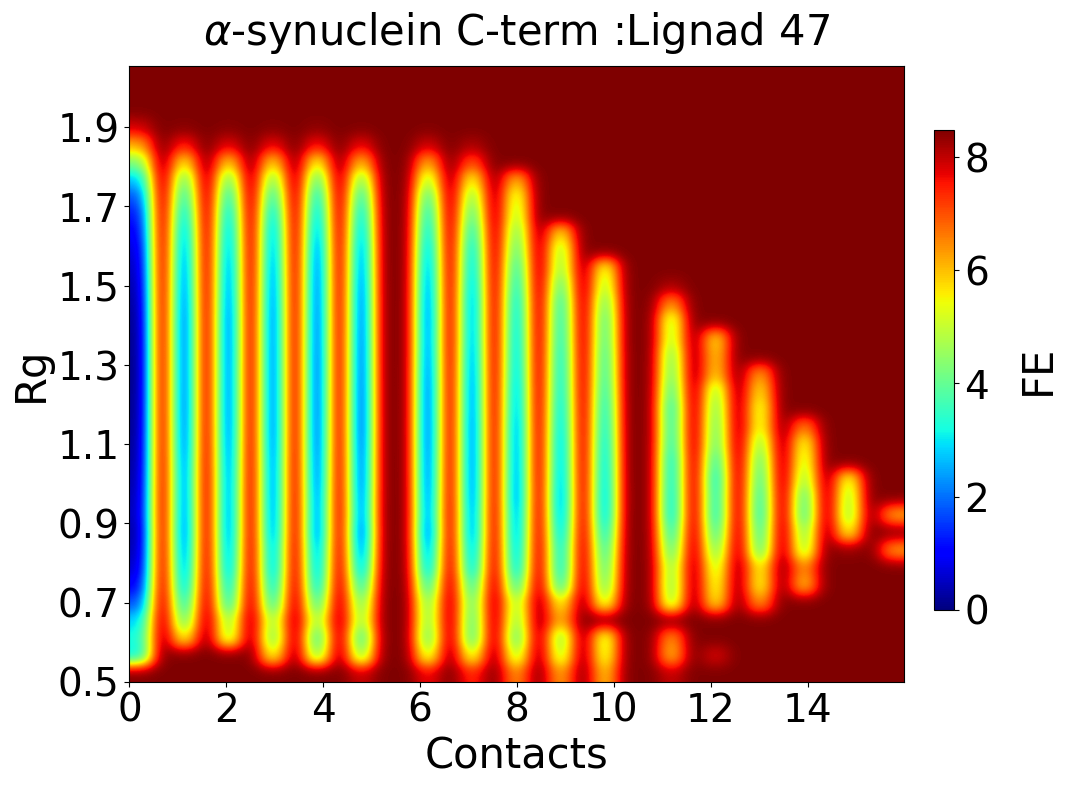

In [291]:
T=300
bins=35

# range=[[X.min()-0.2, X.max()+0.2], [Y.min()-2, Y.max()+2]]
# range=[[0.5, 2.25], [0, 17]]
range=[[X.min(), X.max()], [Y.min(), Y.max()]]

histo, xedges, yedges = np.histogram2d(x=X, y=Y, bins=bins, 
                                       range=range, 
                                       density=True,
                                       weights=weights_norm)

xcenters = xedges[:-1] + np.diff(xedges)/2
ycenters = yedges[:-1] + np.diff(yedges)/2

free_energy = np.log(np.flipud(histo) + 0.000001)
free_energy = -(0.001987 * T) * free_energy
free_energy = free_energy-np.min(free_energy)

images=[]

fig, axes = plt.subplots(1, 1, figsize=(10,8))
cax= fig.add_axes([0.93, 0.2, 0.02, 0.6])

im = axes.imshow(free_energy, cmap='jet', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
            interpolation='gaussian')

images.append(im)
cbar = fig.colorbar(images[-1],cax=cax)
cbar.set_label("FE", size=30, labelpad=20)
cbar.ax.tick_params(labelsize=28)

axes.tick_params(labelsize=28)
axes.set_ylabel('Rg', size=30)
axes.set_xlabel('Contacts', size=30)

axes.set_xticks(np.arange(Y.min(), Y.max(), 2), np.arange(Y.min(), Y.max(), 2), rotation=0)
axes.set_yticks(np.arange(X.min(), X.max(), 0.2), [round(i, 1) for i in np.arange(X.min(), X.max(), 0.2)], rotation=0)
axes.grid(False)
axes.set_title(r'$\alpha$-synuclein C-term :Lignad 47',size=30, pad=15)

In [292]:
fe, xedges,yedges, ferr, err = free_energy_2D_blockerror(Y=X, X=Y, bins=35, T=300, y0=X.min(), ymax=X.max(),
                                                        x0=Y.min(), xmax=Y.max(), weights=weights_norm, blocks=400)

/var/folders/s4/rkgttpts2xl9drlltn1361m00000gn/T/ipykernel_15336/4038208200.py:39: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)


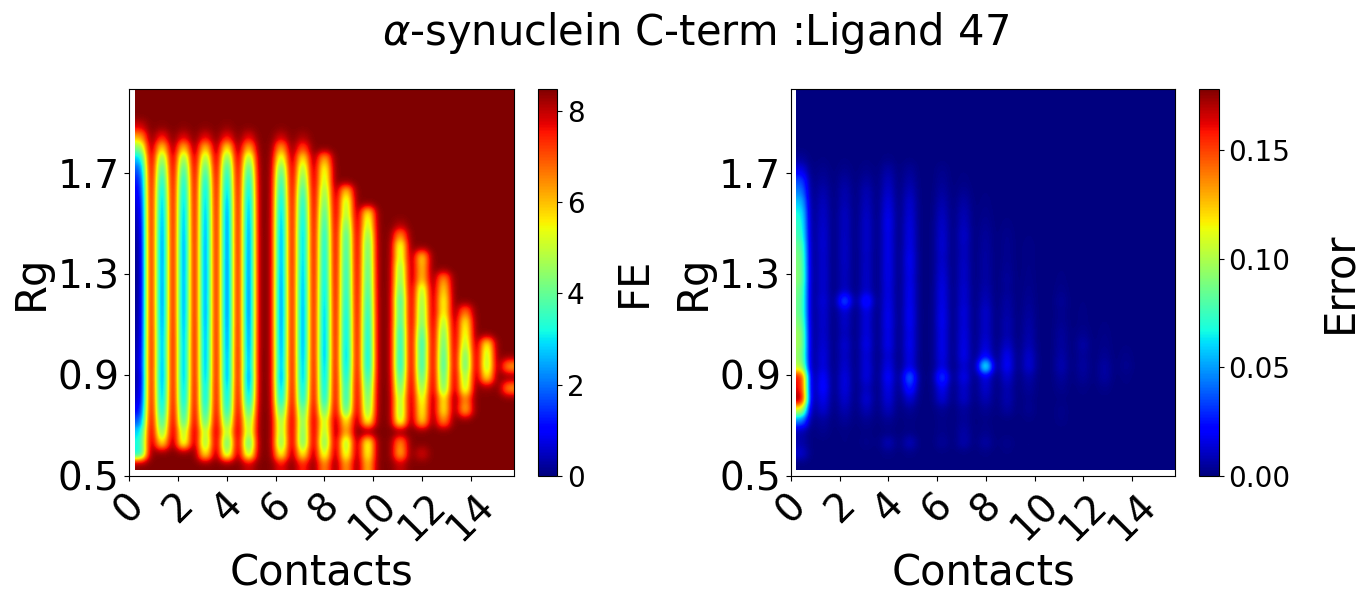

In [293]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
ax=axes.flat

s1 = ax[0].imshow(fe, cmap='jet', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
            interpolation='gaussian')
cbar = fig.colorbar(s1, ax=ax[0])
cbar.set_label("FE", size=30, labelpad=20)
cbar.ax.tick_params(labelsize=20)

ax[0].tick_params(labelsize=28)
ax[0].set_ylabel('Rg', size=30)
ax[0].set_xlabel('Contacts', size=30)

ax[0].set_xticks(np.arange(Y.min(), Y.max(), 2), np.arange(Y.min(), Y.max(), 2), rotation=45)
ax[0].set_yticks(np.arange(X.min(), X.max(), 0.4), [round(i, 1) for i in np.arange(X.min(), X.max(), 0.4)], rotation=0)
ax[0].grid(False)
# ax[0].set_title(r'$\alpha$-synuclein C-term :Fasudil',size=30, pad=15)

s2 = ax[1].imshow(np.flip(adjust_min(err), 0), cmap='jet', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
            interpolation='gaussian')
# plt.colorbar(s2, ax=ax[1], label="Error")
cbar = fig.colorbar(s2, ax=ax[1])
cbar.set_label("Error", size=30, labelpad=20)
cbar.ax.tick_params(labelsize=20)

ax[1].tick_params(labelsize=28)
ax[1].set_ylabel('Rg', size=30)
ax[1].set_xlabel('Contacts', size=30)

ax[1].set_xticks(np.arange(Y.min(), Y.max(), 2), np.arange(Y.min(), Y.max(), 2), rotation=45)
ax[1].set_yticks(np.arange(X.min(), X.max(), 0.4), [round(i, 1) for i in np.arange(X.min(), X.max(), 0.4)], rotation=0)
ax[1].grid(False)

plt.suptitle(r'$\alpha$-synuclein C-term :Ligand 47',size=30, y=1.0)

plt.tight_layout()

In [294]:
bins=2

_, xedges, yedges = np.histogram2d(x=X, y=Y, bins=bins, range=[[X.min(), X.max()], [Y.min(), Y.max()]], density=True)

rg_bor, lc_bor = xedges , yedges
print(rg_bor, lc_bor)

[0.548645  1.3263755 2.104106 ] [ 0.  8. 16.]


In [295]:
q1_1d=np.zeros(len(X))
q2_1d=np.zeros(len(X))
q3_1d=np.zeros(len(X))
q4_1d=np.zeros(len(X))
index=0

for rg,lc in zip(X,Y):

    if rg_bor[0]<=rg<=rg_bor[1] and lc_bor[0]<=lc<=lc_bor[1]: q1_1d[index]=1
    else : q1_1d[index]=0

    if rg_bor[1]<rg<=rg_bor[2] and lc_bor[0]<=lc<=lc_bor[1]: q2_1d[index]=1
    else : q2_1d[index]=0

    if rg_bor[1]<rg<=rg_bor[2] and lc_bor[1]<lc<=lc_bor[2]: q3_1d[index]=1
    else : q3_1d[index]=0

    if rg_bor[0]<=rg<=rg_bor[1] and lc_bor[1]<lc<=lc_bor[2]: q4_1d[index]=1
    else : q4_1d[index]=0

    index+=1
    

In [296]:
print(f'Q1 : {round(rg_bor[0],4)} <= rg <= {round(rg_bor[1], 4)} and {round(lc_bor[0], 4)} <= lc <= {round(lc_bor[1], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip_rw_(q1_1d, weights=weights_norm)}\n')
print(f'Q2 : {round(rg_bor[1],4)} < rg <= {round(rg_bor[2], 4)} and {round(lc_bor[0], 4)} <= lc <= {round(lc_bor[1], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip_rw_(q2_1d, weights=weights_norm)}\n')
print(f'Q3 : {round(rg_bor[1],4)} < rg <= {round(rg_bor[2], 4)} and {round(lc_bor[1], 4)} < lc <= {round(lc_bor[2], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip_rw_(q3_1d, weights=weights_norm)}\n')
print(f'Q4 : {round(rg_bor[0],4)} <= rg <= {round(rg_bor[1], 4)} and {round(lc_bor[1], 4)} < lc <= {round(lc_bor[2], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip_rw_(q4_1d, weights=weights_norm)}\n')


Q1 : 0.5486 <= rg <= 1.3264 and 0.0 <= lc <= 8.0 : 
Prob, B_err : (0.5821014455156369, 0.037178755263030314)

Q2 : 1.3264 < rg <= 2.1041 and 0.0 <= lc <= 8.0 : 
Prob, B_err : (0.3877103077393696, 0.03864798498018996)

Q3 : 1.3264 < rg <= 2.1041 and 8.0 < lc <= 16.0 : 
Prob, B_err : (0.0025930268419585454, 0.0005550828049436808)

Q4 : 0.5486 <= rg <= 1.3264 and 8.0 < lc <= 16.0 : 
Prob, B_err : (0.02759521990303501, 0.0048918106555969265)



## PBMeta-D protein+Ligand 47 (2)

In [297]:
PB_dir = '/Users/jayakrishnakoneru/Documents/work/plots_now/PBMetaD/'
req_dir = 'lig47_2'

colvar_data = np.loadtxt(f'{PB_dir}/{req_dir}/colvar/colvar_0.dat', comments=['#', '@'])
num_cvs, _, weights_norm = norm_weights(f'{PB_dir}/{req_dir}/colvar/colvar_0.dat')

print(f"Sum of combined xtc weights : {np.sum(weights_norm)}")
print(f"Number of frames : {colvar_data.shape[0]}")

Sum of combined xtc weights : 0.9999999999999999
Number of frames : 1600001


In [298]:
file_name = 'contact_matrix.json'
cm = load_json(f'{PB_dir}/{req_dir}/data/out_0/{file_name}')

In [299]:
X=colvar_data.T[index_dict['Rg']] # appears on Y axis
Y=np.sum(cm['0'], axis=1) # appears on X axis

assert X.shape[0]==Y.shape[0], "Shapes are not matching"

data=np.stack([X,Y])

Text(0.5, 1.0, '$\\alpha$-synuclein C-term :Lignad 47')

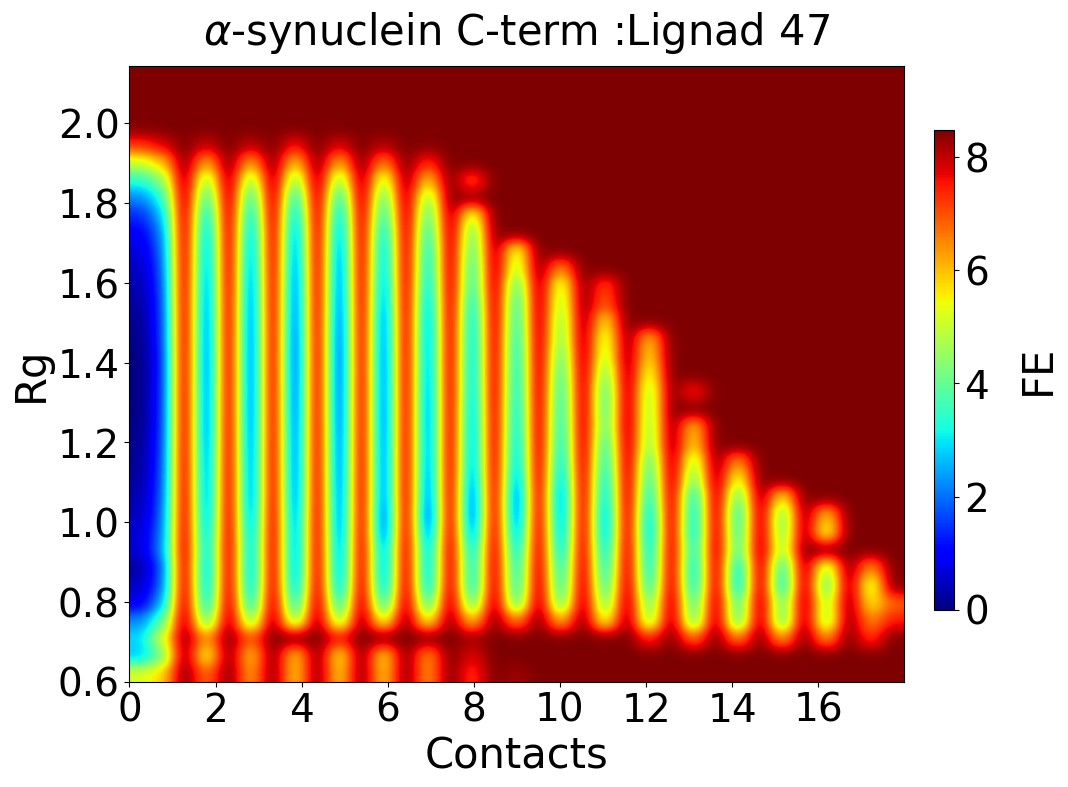

In [300]:
T=300
bins=35

# range=[[X.min()-0.2, X.max()+0.2], [Y.min()-2, Y.max()+2]]
# range=[[0.5, 2.25], [0, 17]]
range=[[X.min(), X.max()], [Y.min(), Y.max()]]

histo, xedges, yedges = np.histogram2d(x=X, y=Y, bins=bins, 
                                       range=range, 
                                       density=True,
                                       weights=weights_norm)

xcenters = xedges[:-1] + np.diff(xedges)/2
ycenters = yedges[:-1] + np.diff(yedges)/2

free_energy = np.log(np.flipud(histo) + 0.000001)
free_energy = -(0.001987 * T) * free_energy
free_energy = free_energy-np.min(free_energy)

images=[]

fig, axes = plt.subplots(1, 1, figsize=(10,8))
cax= fig.add_axes([0.93, 0.2, 0.02, 0.6])

im = axes.imshow(free_energy, cmap='jet', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
            interpolation='gaussian')

images.append(im)
cbar = fig.colorbar(images[-1],cax=cax)
cbar.set_label("FE", size=30, labelpad=20)
cbar.ax.tick_params(labelsize=28)

axes.tick_params(labelsize=28)
axes.set_ylabel('Rg', size=30)
axes.set_xlabel('Contacts', size=30)

axes.set_xticks(np.arange(Y.min(), Y.max(), 2), np.arange(Y.min(), Y.max(), 2), rotation=0)
axes.set_yticks(np.arange(X.min(), X.max(), 0.2), [round(i, 1) for i in np.arange(X.min(), X.max(), 0.2)], rotation=0)
axes.grid(False)
axes.set_title(r'$\alpha$-synuclein C-term :Lignad 47',size=30, pad=15)

In [301]:
fe, xedges,yedges, ferr, err = free_energy_2D_blockerror(Y=X, X=Y, bins=35, T=300, y0=X.min(), ymax=X.max(),
                                                        x0=Y.min(), xmax=Y.max(), weights=weights_norm, blocks=400)

/var/folders/s4/rkgttpts2xl9drlltn1361m00000gn/T/ipykernel_15336/4038208200.py:39: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)


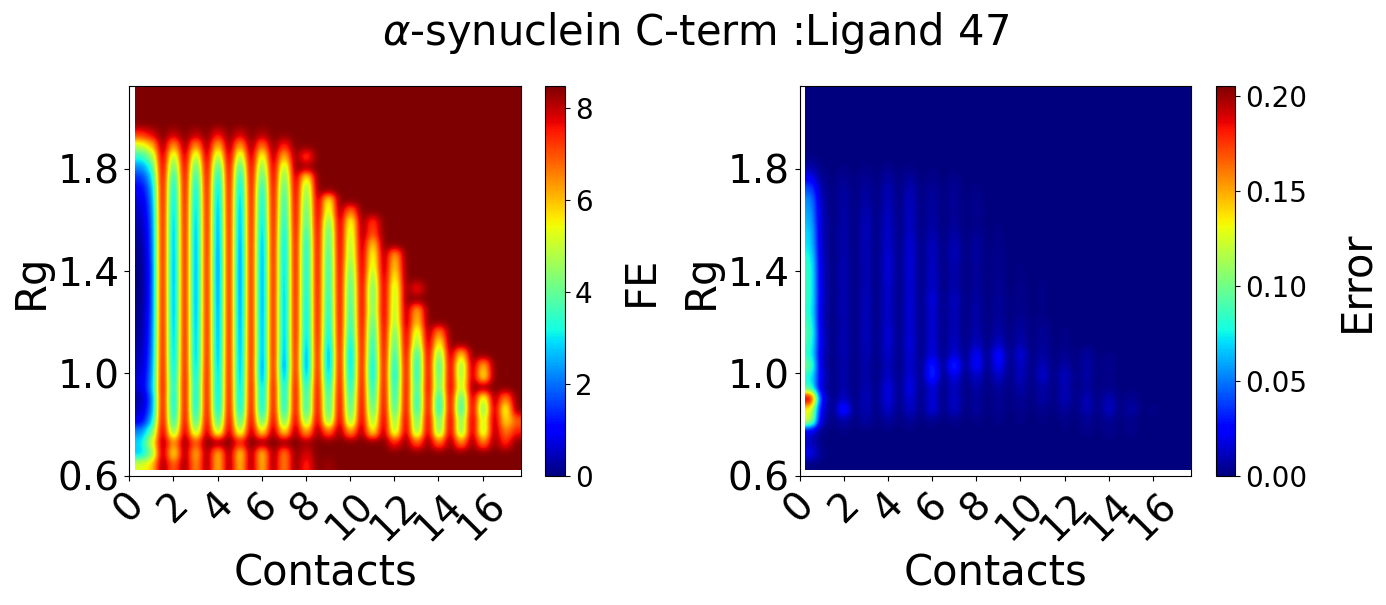

In [302]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
ax=axes.flat

s1 = ax[0].imshow(fe, cmap='jet', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
            interpolation='gaussian')
cbar = fig.colorbar(s1, ax=ax[0])
cbar.set_label("FE", size=30, labelpad=20)
cbar.ax.tick_params(labelsize=20)

ax[0].tick_params(labelsize=28)
ax[0].set_ylabel('Rg', size=30)
ax[0].set_xlabel('Contacts', size=30)

ax[0].set_xticks(np.arange(Y.min(), Y.max(), 2), np.arange(Y.min(), Y.max(), 2), rotation=45)
ax[0].set_yticks(np.arange(X.min(), X.max(), 0.4), [round(i, 1) for i in np.arange(X.min(), X.max(), 0.4)], rotation=0)
ax[0].grid(False)
# ax[0].set_title(r'$\alpha$-synuclein C-term :Fasudil',size=30, pad=15)

s2 = ax[1].imshow(np.flip(adjust_min(err), 0), cmap='jet', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
            interpolation='gaussian')
# plt.colorbar(s2, ax=ax[1], label="Error")
cbar = fig.colorbar(s2, ax=ax[1])
cbar.set_label("Error", size=30, labelpad=20)
cbar.ax.tick_params(labelsize=20)

ax[1].tick_params(labelsize=28)
ax[1].set_ylabel('Rg', size=30)
ax[1].set_xlabel('Contacts', size=30)

ax[1].set_xticks(np.arange(Y.min(), Y.max(), 2), np.arange(Y.min(), Y.max(), 2), rotation=45)
ax[1].set_yticks(np.arange(X.min(), X.max(), 0.4), [round(i, 1) for i in np.arange(X.min(), X.max(), 0.4)], rotation=0)
ax[1].grid(False)

plt.suptitle(r'$\alpha$-synuclein C-term :Ligand 47',size=30, y=1.0)

plt.tight_layout()

In [303]:
bins=2

_, xedges, yedges = np.histogram2d(x=X, y=Y, bins=bins, range=[[X.min(), X.max()], [Y.min(), Y.max()]], density=True)

rg_bor, lc_bor = xedges , yedges
print(rg_bor, lc_bor)

[0.564763  1.3370625 2.109362 ] [ 0.  9. 18.]


In [304]:
q1_1d=np.zeros(len(X))
q2_1d=np.zeros(len(X))
q3_1d=np.zeros(len(X))
q4_1d=np.zeros(len(X))
index=0

for rg,lc in zip(X,Y):

    if rg_bor[0]<=rg<=rg_bor[1] and lc_bor[0]<=lc<=lc_bor[1]: q1_1d[index]=1
    else : q1_1d[index]=0

    if rg_bor[1]<rg<=rg_bor[2] and lc_bor[0]<=lc<=lc_bor[1]: q2_1d[index]=1
    else : q2_1d[index]=0

    if rg_bor[1]<rg<=rg_bor[2] and lc_bor[1]<lc<=lc_bor[2]: q3_1d[index]=1
    else : q3_1d[index]=0

    if rg_bor[0]<=rg<=rg_bor[1] and lc_bor[1]<lc<=lc_bor[2]: q4_1d[index]=1
    else : q4_1d[index]=0

    index+=1
    

In [305]:
print(f'Q1 : {round(rg_bor[0],4)} <= rg <= {round(rg_bor[1], 4)} and {round(lc_bor[0], 4)} <= lc <= {round(lc_bor[1], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip_rw_(q1_1d, weights=weights_norm)}\n')
print(f'Q2 : {round(rg_bor[1],4)} < rg <= {round(rg_bor[2], 4)} and {round(lc_bor[0], 4)} <= lc <= {round(lc_bor[1], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip_rw_(q2_1d, weights=weights_norm)}\n')
print(f'Q3 : {round(rg_bor[1],4)} < rg <= {round(rg_bor[2], 4)} and {round(lc_bor[1], 4)} < lc <= {round(lc_bor[2], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip_rw_(q3_1d, weights=weights_norm)}\n')
print(f'Q4 : {round(rg_bor[0],4)} <= rg <= {round(rg_bor[1], 4)} and {round(lc_bor[1], 4)} < lc <= {round(lc_bor[2], 4)} : \nProb, B_err : {get_blockerror_pyblock_nanskip_rw_(q4_1d, weights=weights_norm)}\n')


Q1 : 0.5648 <= rg <= 1.3371 and 0.0 <= lc <= 9.0 : 
Prob, B_err : (0.6003919163214446, 0.03485930331911111)

Q2 : 1.3371 < rg <= 2.1094 and 0.0 <= lc <= 9.0 : 
Prob, B_err : (0.3710494545718659, 0.03754713373192493)

Q3 : 1.3371 < rg <= 2.1094 and 9.0 < lc <= 18.0 : 
Prob, B_err : (0.00033009195336998286, 9.4517496772593e-05)

Q4 : 0.5648 <= rg <= 1.3371 and 9.0 < lc <= 18.0 : 
Prob, B_err : (0.028228537153319716, 0.007156744717215681)

